# Mortality Rates in Ireland – Data Analysis & Prediction

**Author:** Loic Soares Bagnoud  
**Data Source:** Central Statistics Office (CSO) – Ireland  
**Notebook Purpose:**  
- Clean and explore mortality rate data for Ireland  
- Identify trends and correlations across years, regions, causes of death, and demographics  

## 1. Cleaning up Data 

### 1.1 Importing libraries, loading the data and understanding the columns

The first thing that we need to do is make sure that our raw data is readable and without any issues. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
csv_path = "raw_data/MORT02.20251120T191125.csv"
df = pd.read_csv(csv_path)
df.head(5)

Statistic Label  Year         Sex   County     Age Group  \
0  Age-standardised mortality rate  2015  Both sexes  Ireland  0 - 64 years   
1  Age-standardised mortality rate  2015  Both sexes  Ireland  0 - 64 years   
2  Age-standardised mortality rate  2015  Both sexes  Ireland  0 - 64 years   
3  Age-standardised mortality rate  2015  Both sexes  Ireland  0 - 64 years   
4  Age-standardised mortality rate  2015  Both sexes  Ireland  0 - 64 years   

                      Cause of Death  UNIT   VALUE  
0                All causes of death  Rate  161.63  
1  Infectious and parasitic diseases  Rate    1.75  
2                       Tuberculosis  Rate    0.15  
3            Meningococcal infection  Rate    0.04  
4                 Aids (HIV disease)  Rate    0.19

We can see from the above that we're working with a couple of things here. There are specific columns that we won't need for this which will be __*UNIT*__ and __*Statistic Label*__. 
Everything else will be necessary:
>
- The __*Year*__ will allow us to check trends by year across the country.
- We will try and see if there is anything interesting to be gained from both __*sexes*__.
- The __*Age Group*__ will allow us to see if there any problematic ages.
- The __*Cause of Death*__ will give us insight to the actual causes of the mortality rate numbers
- And finally, the __*VALUE*__ is self-explanatory.

In [32]:
# This will allows us to drop the columns that we don't need.
drop_col_list = ['Statistic Label', 'UNIT']
df.drop(columns=drop_col_list, inplace=True)
df.head(5)

Year         Sex   County     Age Group                     Cause of Death  \
0  2015  Both sexes  Ireland  0 - 64 years                All causes of death   
1  2015  Both sexes  Ireland  0 - 64 years  Infectious and parasitic diseases   
2  2015  Both sexes  Ireland  0 - 64 years                       Tuberculosis   
3  2015  Both sexes  Ireland  0 - 64 years            Meningococcal infection   
4  2015  Both sexes  Ireland  0 - 64 years                 Aids (HIV disease)   

    VALUE  
0  161.63  
1    1.75  
2    0.15  
3    0.04  
4    0.19

### 1.3 Data quality checks

With our coloumns dropped, we can now go ahead and see if there's any missing data from our dataframe. For this, we can use the __*.isna*__ function

In [33]:
# We use this to check if there's any missing values in each column and we sum it up.
missing_counts = df.isna().sum()
missing_counts

Year              0
Sex               0
County            0
Age Group         0
Cause of Death    0
VALUE             0
dtype: int64

No missing values, which is great. Let's also try and see if all values have the correct datatype.

In [34]:
# This gets us the datatypes for each column group.
data_types = df.dtypes
data_types

Year                int64
Sex                object
County             object
Age Group          object
Cause of Death     object
VALUE             float64
dtype: object

We have ints for __*Year*__ and floats for the __*VALUES*__ (which is expected since it's percentages). Everything else is an object which makes sense given the fact it's all text.

In [35]:
# With this function, we can see which values are duplicated in the dataframe
duplicates = df[df.duplicated()]
duplicates

Empty DataFrame
Columns: [Year, Sex, County, Age Group, Cause of Death, VALUE]
Index: []

I found the above particularly weird but I imagine it meant that it found nothing. I clarified with ChatGPT. 3

In [36]:
# We sum up the duplicates just to make sure we're not missing anything. If the number is 0, this means there aren't really any duplicates.
duplicates_making_sure = df.duplicated().sum()
duplicates_making_sure

0

The next thing I needed to also check is if there are any 0 values. It would be incredibly weird if any value at all had 0 deaths, be it gender, years, cause of death, etc. Meaning that we need to catch those and then decide what we're doing to do with them. The following function on Stackoverflow helps with that. 4

In [37]:
# The following function allows us to check the dataframe and will return True if all values in a df are 0 and False if not.

# Source - https://stackoverflow.com/a
# Posted by Ziur Olpa
# Retrieved 2025-12-04, License - CC BY-SA 4.0

if (df['VALUE'] == 0).all():
    print('all')
if (df['VALUE'] == 0).any():
    print('any')


any


Alright, we do know there are possible 0 deaths happening with specific combinations of genders, diseases and locations. We'll need to take that into consideration later on.

With all sanity checks done, comes the difficult question. What to do with the age groups? It's problematic because we don't really have various ages like 1,2,3,etc. but two big age goups:
>
- 0–64 years
- 0–74 years
>
After some research, I managed to find out that this it is related to **cumulative incidence rate**5 but applied to mortality. Meaning that I do need to keep them. However, the reason for 64 and 74 is that while both research premature mortality, the WHO/EU tends to go up to 74/75.6

Given this, I decided to simply drop 0-74 and 74+ because we won't be working with this standard.7

In [38]:
# We assign a variable to our chosen dropped values.
droped_ages = ['0 - 74 years', '75 years and over']

# This part was a little tricky as I couldn't find how to actually remove specific values from columns. Eventually that led to a Medium article that used the .isin function with a boolean. 
# A form of boolean indexing. In other words, we now use a boolean operator to check for each row whether its Age Group value is in the variable we made.
# Once it finished, the "~" flips them over so now, the specific values become false and Pandas keeps only the rows where the condition is True.
df = df[~df['Age Group'].isin(droped_ages)]

# We check if the others remain. 
df['Age Group'].unique()


array(['0 - 64 years', '65 years and over', 'All ages'], dtype=object)

Finally, I think it's preferable to keep these numbers to solidify our two age groups. But we do need to at least update them to make sure anyone seeing this knows that we're actually working with those two age groups. We can achieve this with a dictionary as well.8

In [39]:
# We create a brand new dictionary, making sure our values match the ones in the data set. 
new_age_group_names = {
    '0 - 64 years': 'Younger/Working age adults (0-64)',
    '65 years and over': 'Retired/Older adults(65+)',
}

# We then use the .replace function here to replace those valus in the Age Group column. 
df['Age Group'] = df['Age Group'].replace(new_age_group_names)

# Check the result
print(df['Age Group'].unique())
df.head(5)

['Younger/Working age adults (0-64)' 'Retired/Older adults(65+)'
 'All ages']


Year         Sex   County                          Age Group  \
0  2015  Both sexes  Ireland  Younger/Working age adults (0-64)   
1  2015  Both sexes  Ireland  Younger/Working age adults (0-64)   
2  2015  Both sexes  Ireland  Younger/Working age adults (0-64)   
3  2015  Both sexes  Ireland  Younger/Working age adults (0-64)   
4  2015  Both sexes  Ireland  Younger/Working age adults (0-64)   

                      Cause of Death   VALUE  
0                All causes of death  161.63  
1  Infectious and parasitic diseases    1.75  
2                       Tuberculosis    0.15  
3            Meningococcal infection    0.04  
4                 Aids (HIV disease)    0.19

With our data now cleaned and prepared, we can go ahead and export this to a brand new CSV file that we can work off of.

In [40]:
# This exports it to a csv
df.to_csv('cleaned_data/cleaned_data.csv', index=False)

## 2. Exploratory Data Analysis (EDA): Trends & Correlations

### 2.1 Overall distribution of mortality ratios

The first step of the analysis might be to start off with a preliminary overall distribution of mortality across several data points. we can start off by looking at some overall summary stats.

In [2]:
# We make sure we're using our new cleaned data and check if it's loading properly
cleaned_data ="cleaned_data/cleaned_data.csv"
df = pd.read_csv(cleaned_data)
df.head(5)

Year         Sex   County                          Age Group  \
0  2015  Both sexes  Ireland  Younger/Working age adults (0-64)   
1  2015  Both sexes  Ireland  Younger/Working age adults (0-64)   
2  2015  Both sexes  Ireland  Younger/Working age adults (0-64)   
3  2015  Both sexes  Ireland  Younger/Working age adults (0-64)   
4  2015  Both sexes  Ireland  Younger/Working age adults (0-64)   

                      Cause of Death   VALUE  
0                All causes of death  161.63  
1  Infectious and parasitic diseases    1.75  
2                       Tuberculosis    0.15  
3            Meningococcal infection    0.04  
4                 Aids (HIV disease)    0.19

In [3]:
# We use the .describe function to get some summary statistics.
df['VALUE'].describe()

count    167670.000000
mean         86.844827
std         364.688966
min           0.000000
25%           0.000000
50%           4.620000
75%          34.570000
max        6511.780000
Name: VALUE, dtype: float64

As we can see, these are very weird numbers. The Standard Deviation is incredibly high and the 25 percentile is valued at 0. This means that we have a high dispersion of numbers and that the data is heavily skewed given population densities.9 As mentioned during the cleanup data step, we do have a lot of 0 deaths present, which would be expected and this will certainly account for the high Standard Deviation. 

### 2.2 Trends over time (national level)

Let's do ahead and create our plot to see what's happening. We'll try and get the overall mortality rate in the entire country across the years (2015-2024).

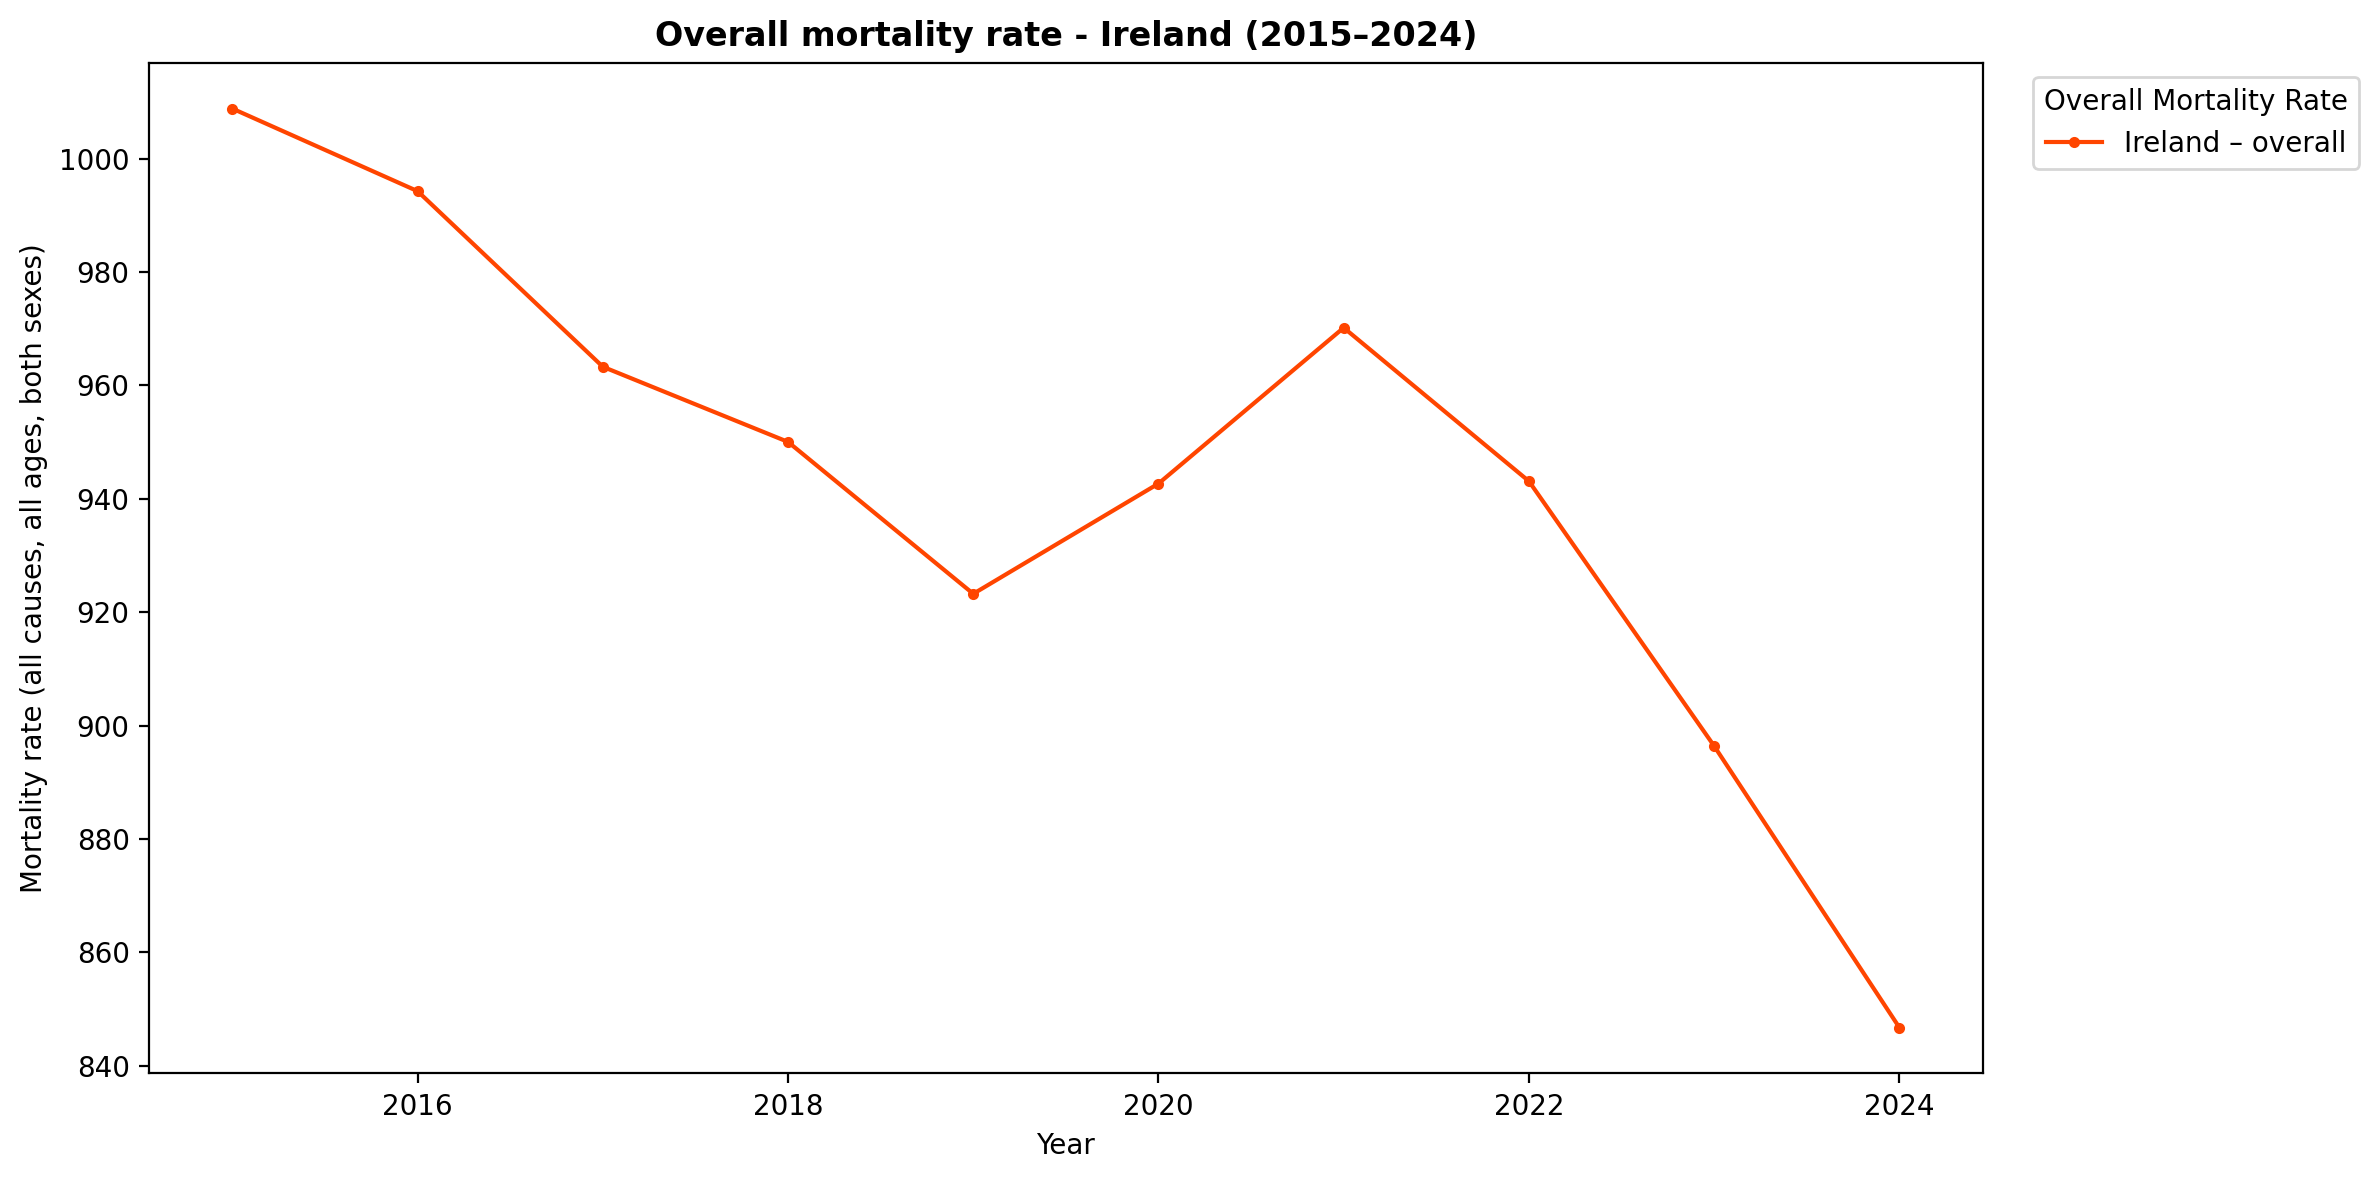

In [4]:
# Well first need to filter the values we want. Since it's across all ages, sexes and counties, we need to get those columns first and sort them by year.
ireland_overall = df[
    (df['County'] == 'Ireland') &
    (df['Sex'] == 'Both sexes') &
    (df['Age Group'] == 'All ages') &
    (df['Cause of Death'] == 'All causes of death')
].sort_values('Year')

# We then create our line plot. 
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# We set our values and our line with the correct colours and markers, followed by the correct labels.
ax.plot(
    ireland_overall['Year'],
    ireland_overall['VALUE'],
    color='orangered',
    marker='.',
    label='Ireland – overall'
)
ax.set_xlabel('Year')
ax.set_ylabel('Mortality rate (all causes, all ages, both sexes)')
ax.set_title('Overall mortality rate - Ireland (2015–2024)', fontweight='bold')

# Add the legend, positioned to the right since Matplotlib wasn't adding a legend by default and I had to research on how to do it.
ax.legend(
    title="Overall Mortality Rate",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0)  
)

# Finally, show it
fig.tight_layout()
plt.show()

# References for Code:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html
# https://matplotlib.org/stable/users/explain/text/text_props.html
# https://matplotlib.org/stable/tutorials/pyplot.html

We can see that the Mortality is going down substantially. There was a bit of a rise after 2019 up to 2021, but this seems to coincide with the Pandemic (Covid-19). Afterwards, we can see a very sharp drop, which means that overall, Ireland is doing pretty great.
>
Let's try and have a look at the sexes and see how it's looking across the years as well.

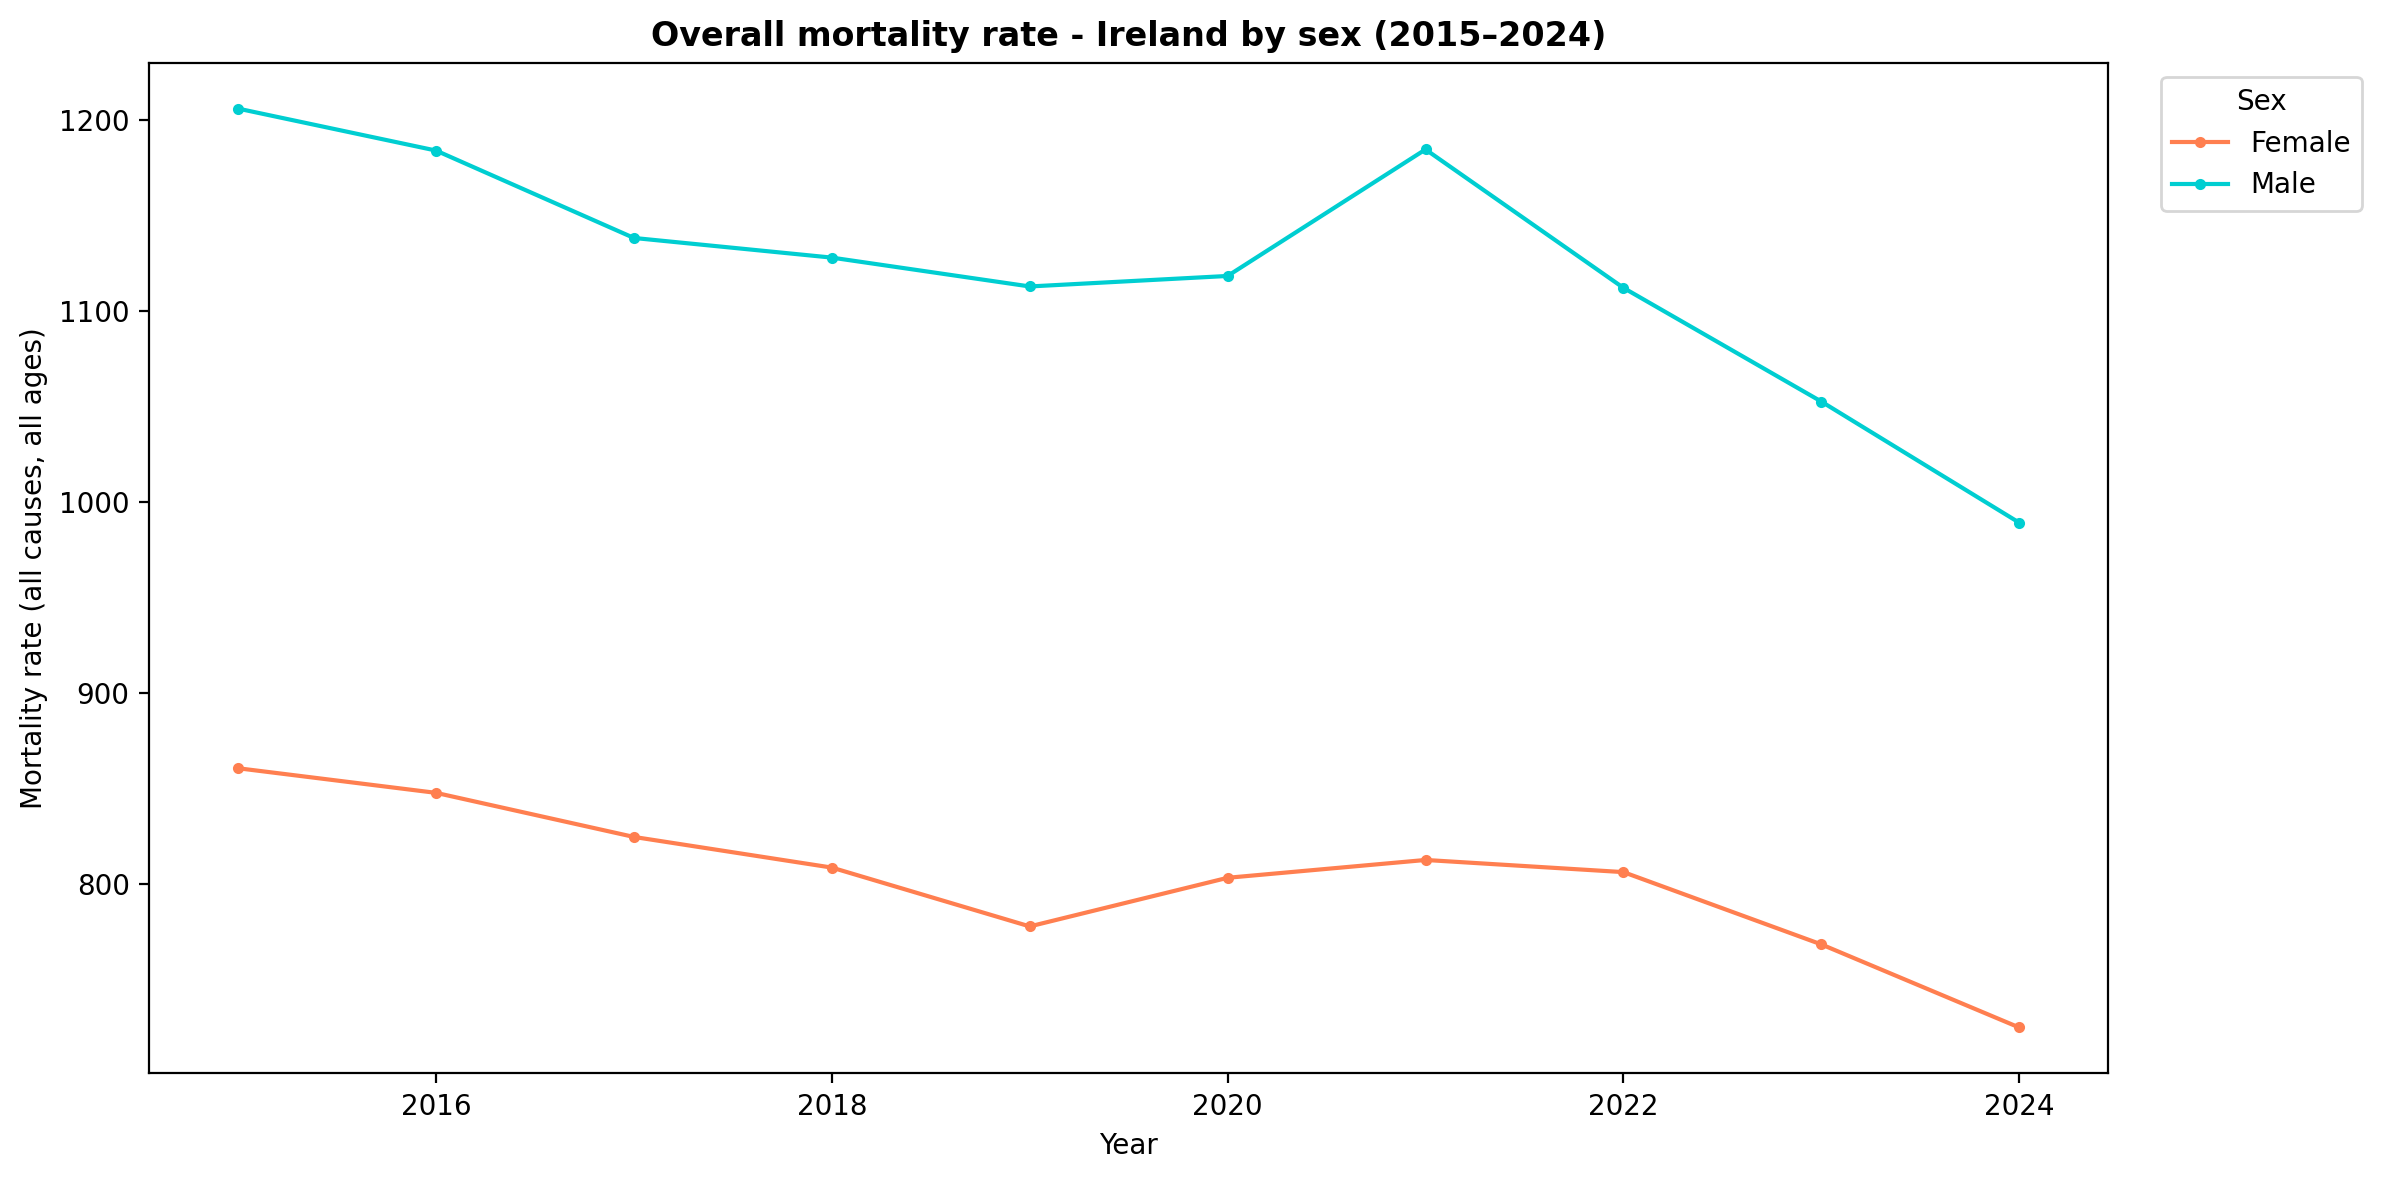

In [5]:
# We will follow the same logic as before, but this time we explicitely ask not to show us both sexes, so that we can get "male" and "female".
ireland_by_sex = df[
    (df['County'] == 'Ireland') &
    (df['Sex'] != 'Both sexes') &
    (df['Age Group'] == 'All ages') &
    (df['Cause of Death'] == 'All causes of death')
].sort_values('Year')

# We create our canvas
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# We had a dictionary for our colours, since we want different colours for the different things we're analysing.
color_for_sexes = {
    'Male': 'darkturquoise',     
    'Female': 'coral',
}

# We use this for loop to iterate through both sexes and sort it by years and we then plot the same way as we did before for the overall.
for sex, group in ireland_by_sex.groupby('Sex'):
    group = group.sort_values('Year')
    ax.plot(
        group['Year'],
        group['VALUE'],
        marker='.',
        label=sex,
        color=color_for_sexes.get(sex, 'black') 
    )

# The rest of the code stays the same.
ax.set_xlabel('Year')
ax.set_ylabel('Mortality rate (all causes, all ages)')
ax.set_title('Overall mortality rate - Ireland by sex (2015–2024)', fontweight='bold')

ax.legend(title='Sex', loc='upper left', bbox_to_anchor=(1.02, 1.0))

fig.tight_layout()
plt.show()

As we can see, same as our overall, both sexes have a sharp decrease in deaths as the years go by. However, what's interesting to note here, is the fact men, continue having more deaths than women. 

### 2.3 Regional patterns

With our sexes analysed, let's try and have a look at at the regions (counties) and see how the mortality rate trends across the years. 

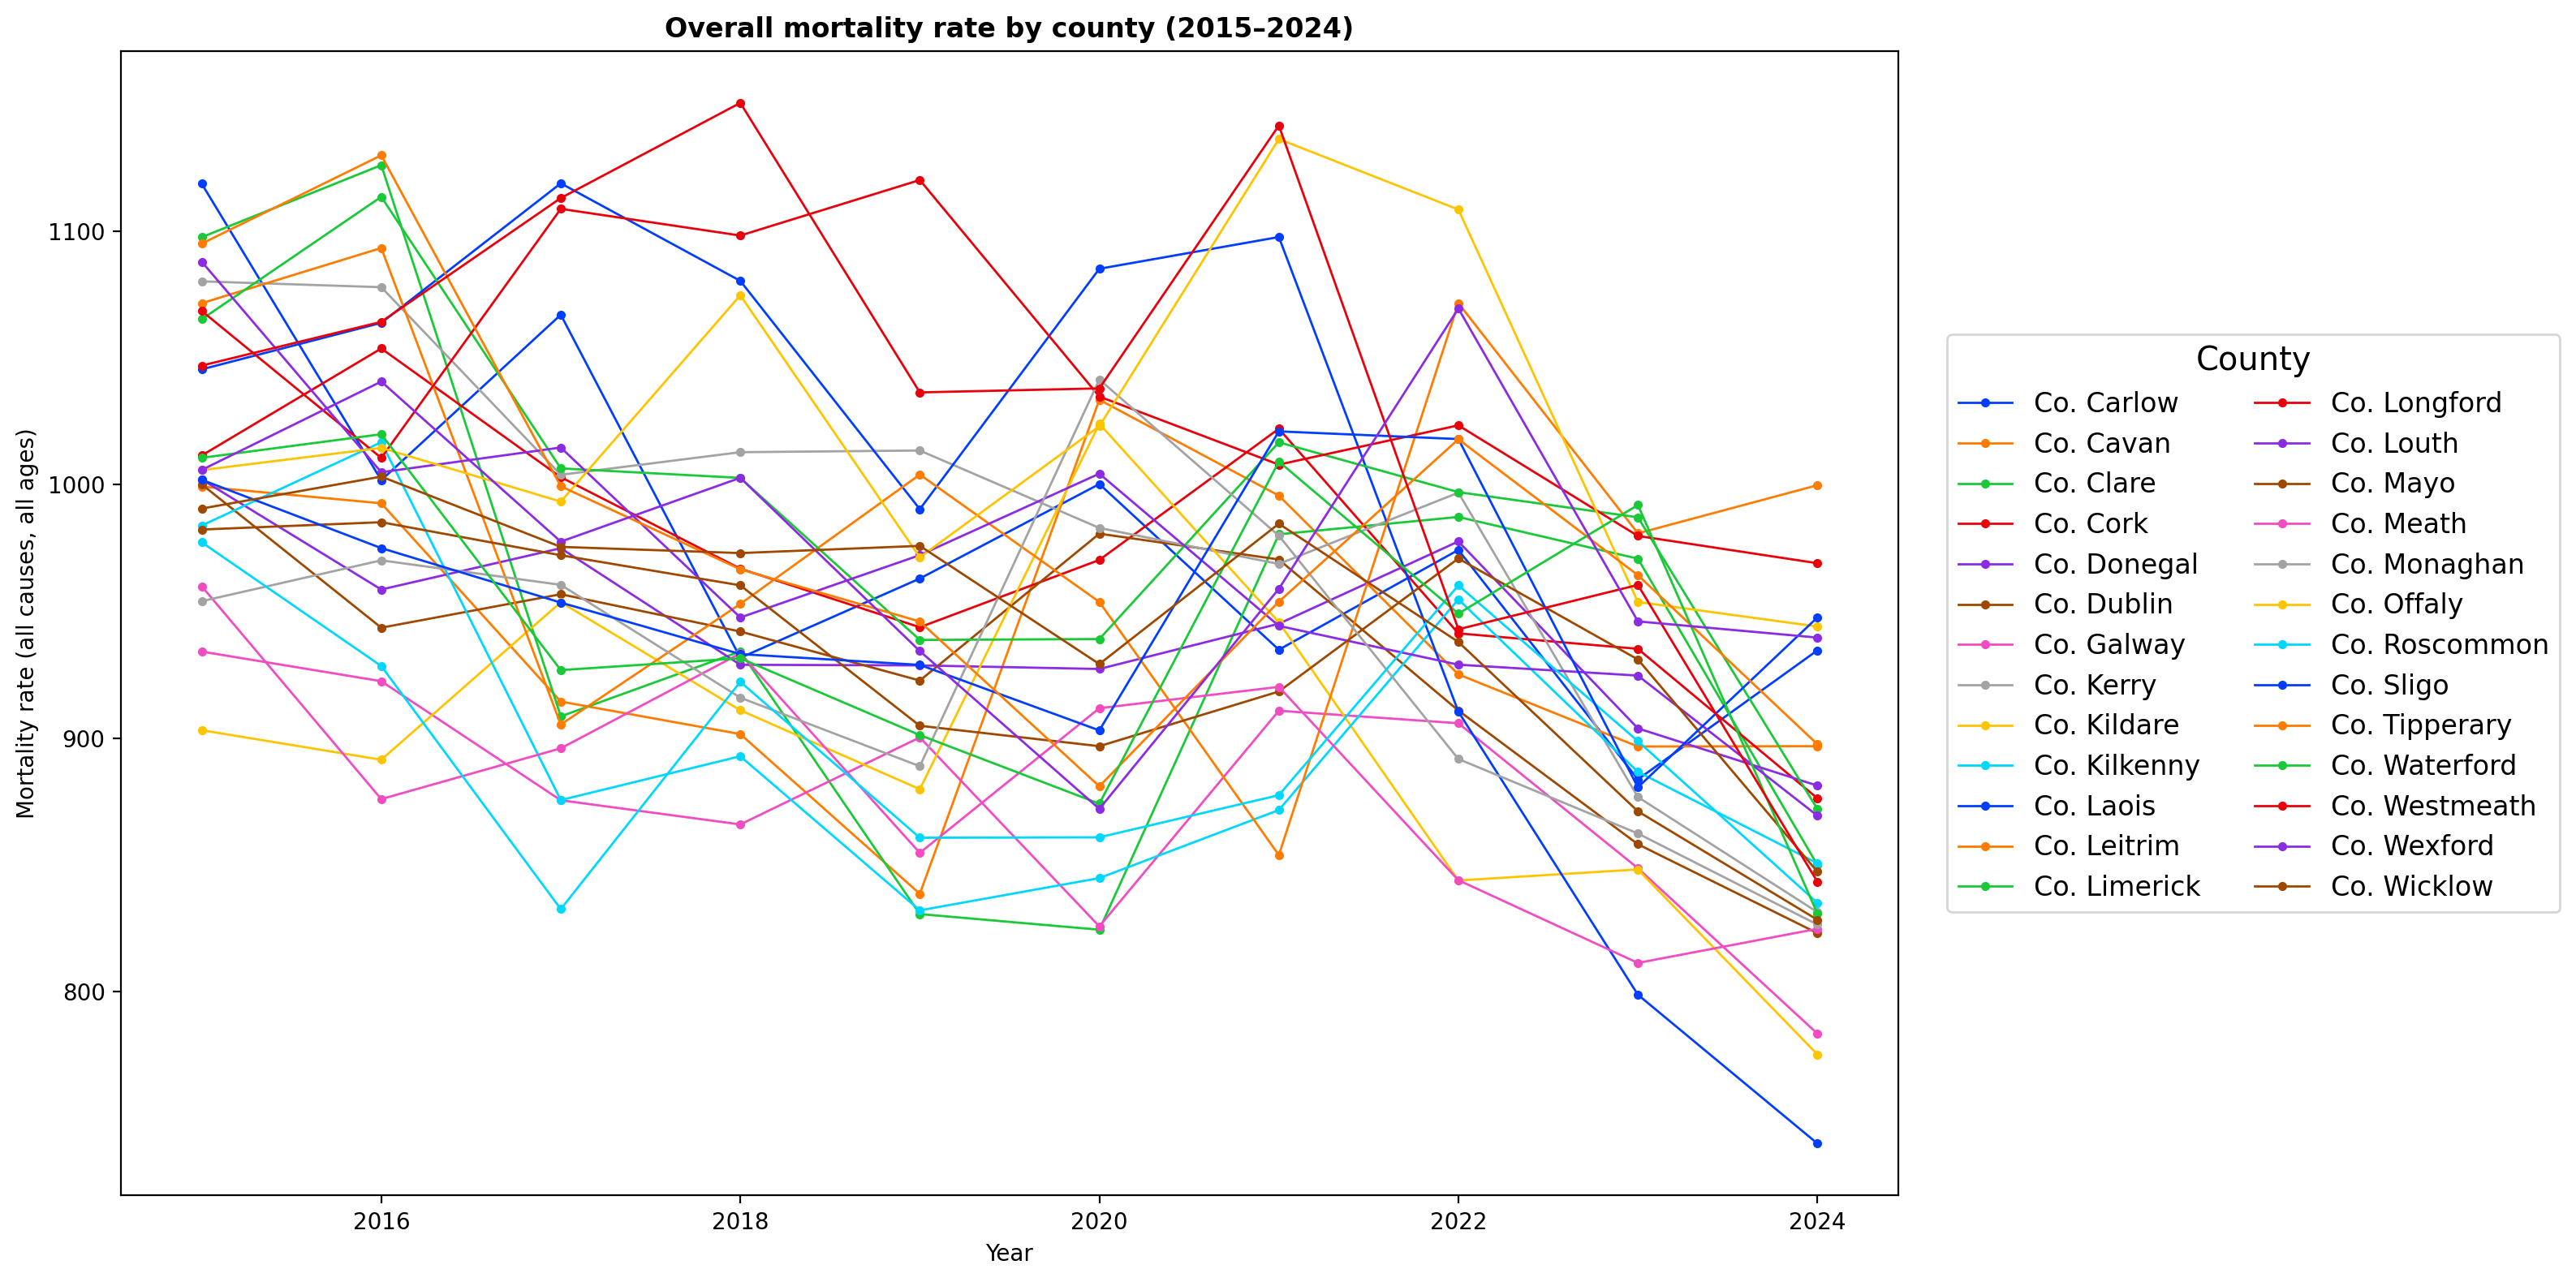

In [6]:
# We filter our data first. Same as we did before. We also make ure to exclude Ireland, since it will have the highest number and we're not interested in this.
regional_data = df[
    (df['County'] != 'Ireland') &
    (df['Sex'] == 'Both sexes') &
    (df['Age Group'] == 'All ages') &
    (df['Cause of Death'] == 'All causes of death')
].sort_values(['County', 'Year'])

# We get all the unique county values so that we can assign each a unique colour.
counties = regional_data['County'].unique()
num_counties = len(counties)

# I used seaborn for this, since I prefer their colour palettes to the default Matplotlib library.
palette = sns.color_palette('bright', num_counties) 

# We create our plot
fig, ax = plt.subplots(figsize=(16, 8), dpi=200)

# We plot each county with its own color from the palette. For this, I was able to use the .enumerate function and the groupby function to iterate through
# each county and its associated colour from the palette.
for i, (county, group) in enumerate(regional_data.groupby('County')):
    group = group.sort_values('Year')
    ax.plot(
        group['Year'],
        group['VALUE'],
        label=county,
        marker='.',
        linewidth=1,
        color=palette[i]  
    )

# We had our descriptions
ax.set_xlabel('Year')
ax.set_ylabel('Mortality rate (all causes, all ages)')
ax.set_title('Overall mortality rate by county (2015–2024)', fontweight='bold')

# As well as our legend. I tried enlarging it a bit
ax.legend(
    title='County',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize='large',
    title_fontsize='x-large',
    # The legend was extremely cluttered, so I split it into two equal columns.
    ncol=2  
)
fig.tight_layout()
plt.show()

# References: 
# https://realpython.com/python-enumerate/ - For .enumerate
# https://matplotlib.org/stable/api/legend_api.html - For text size and number of columns

As we can see, while this looks clear and we can see some overalls and even some trends (going down for all counties), there are not enough colours in the Pallete for the number of counties which is problematic. I wasn't sure how to fix this, so I started looking into other types of plot types that could better represent this data.10
> 
I tried with a heatplot, since I think it could really help us here.

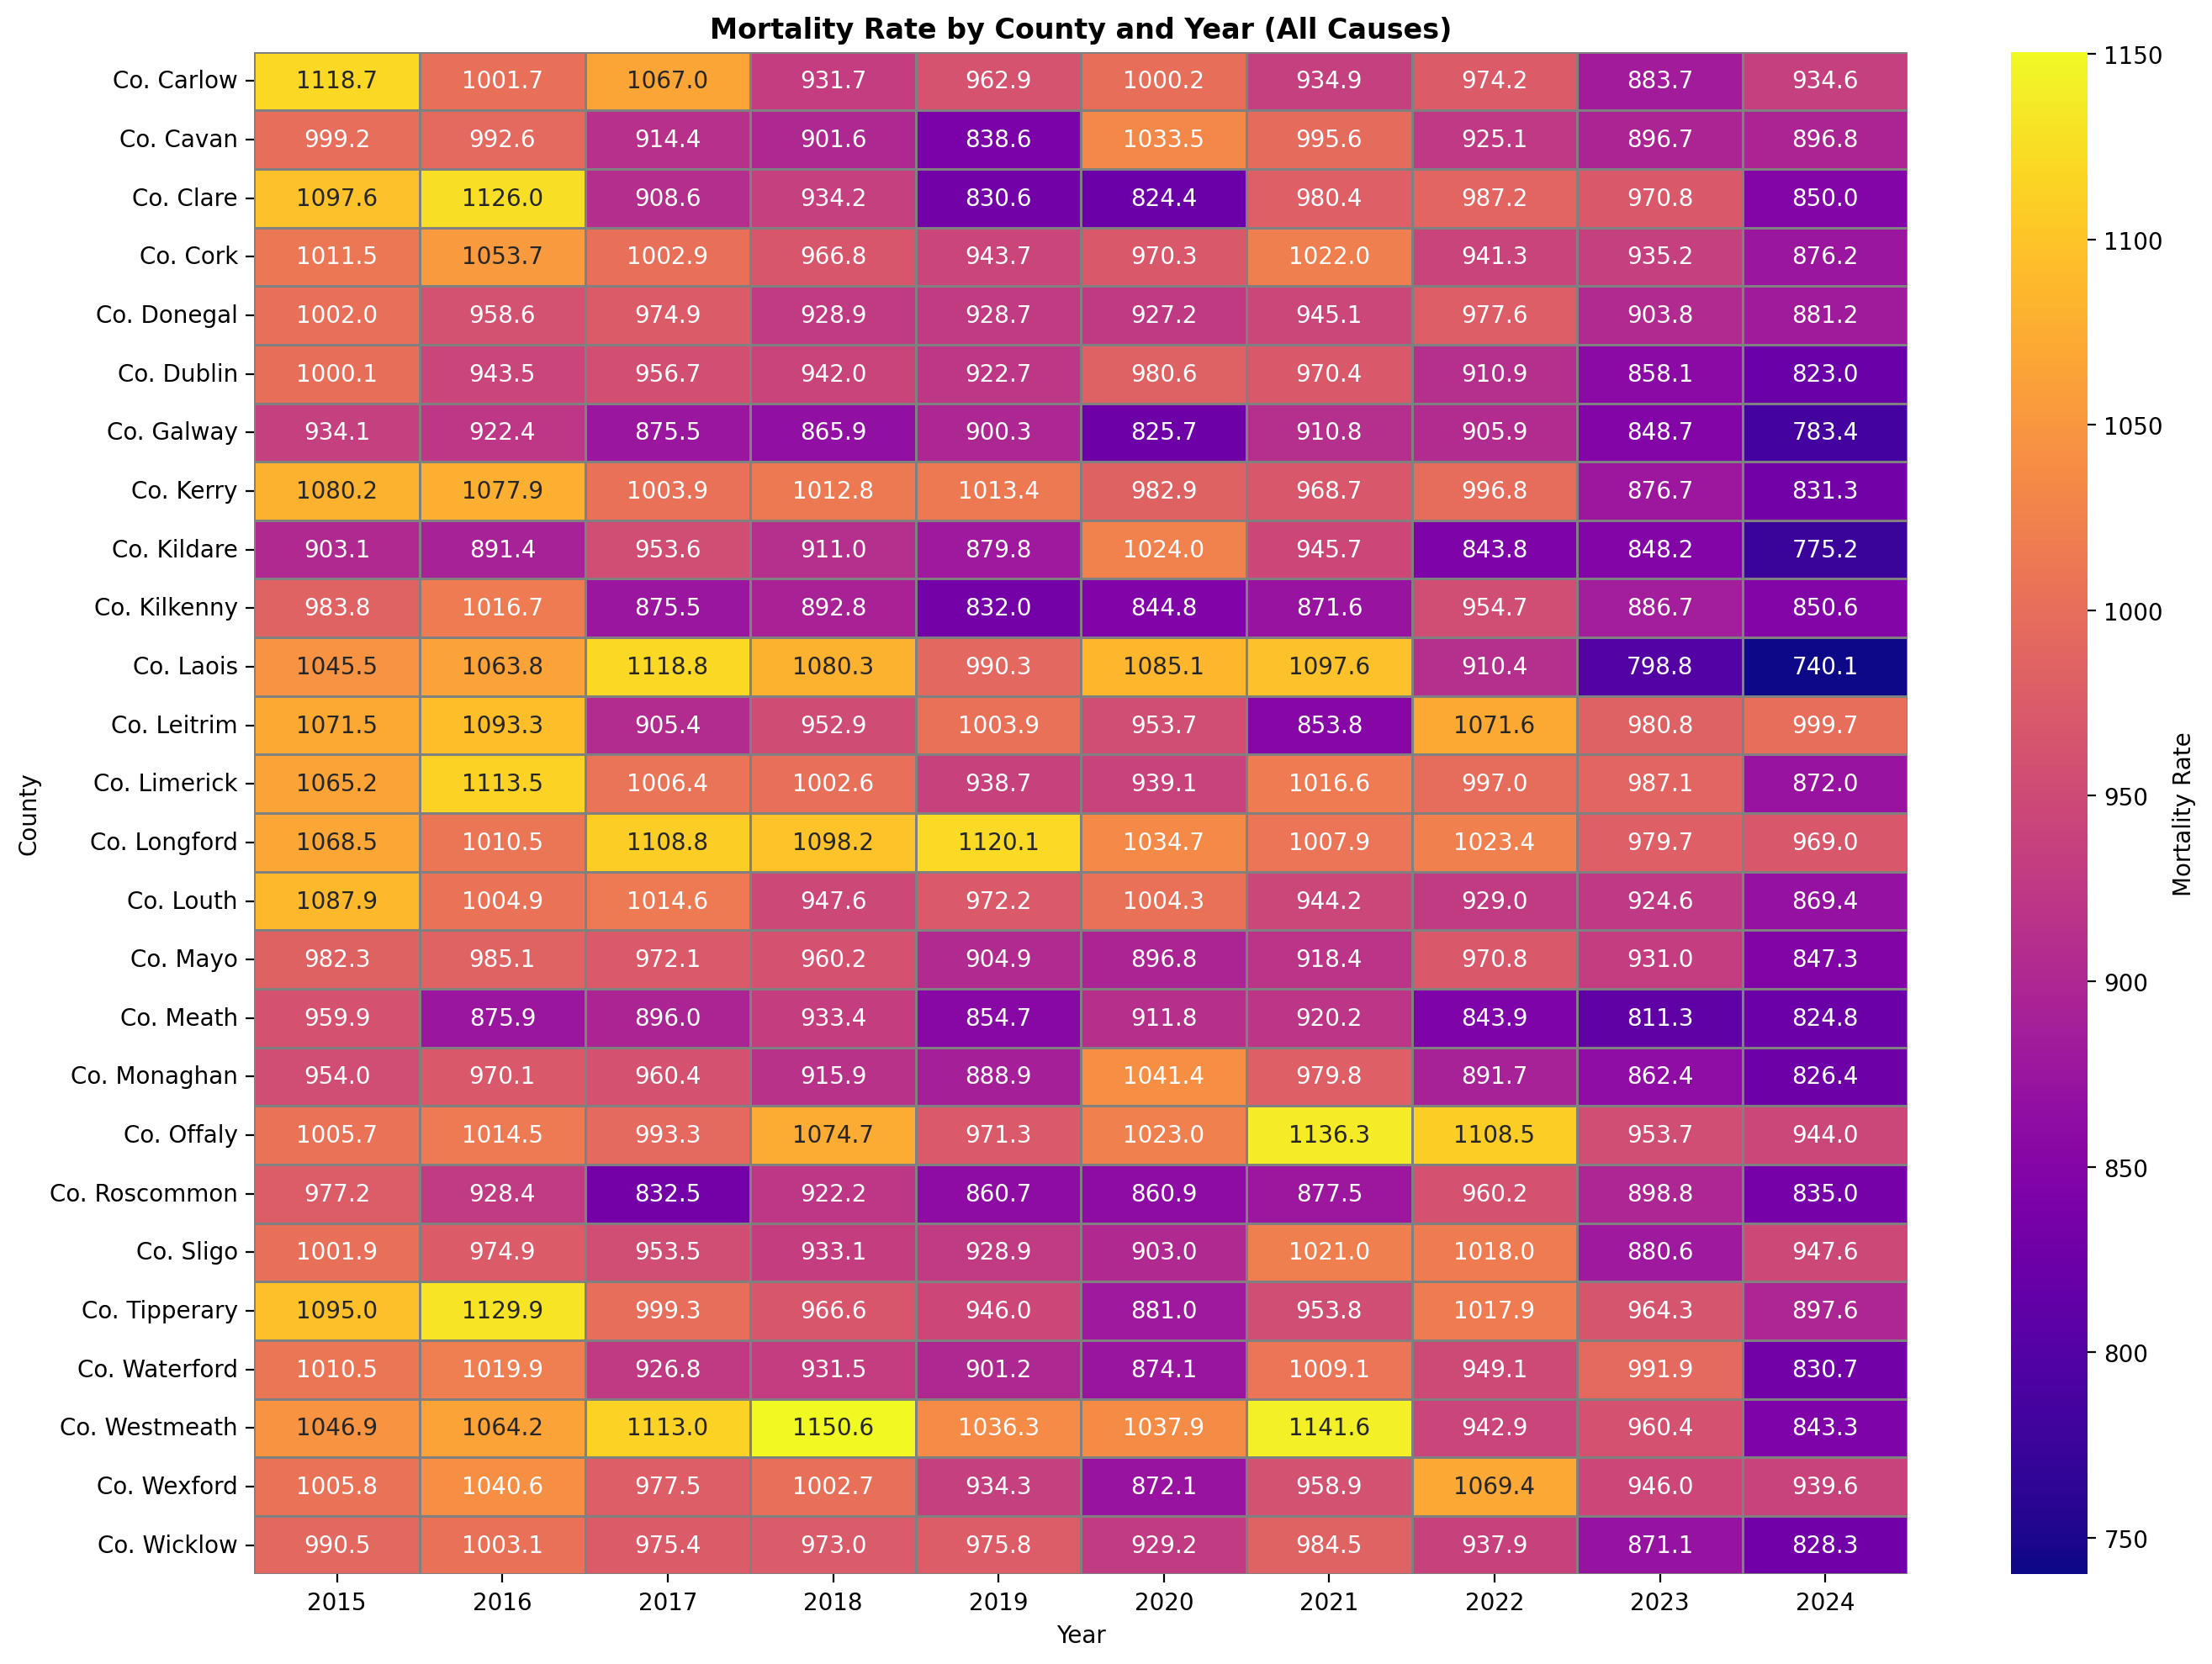

In [7]:
# We make a pivot table for our counties and their values by year.
heatmap_data = regional_data.pivot(index='County', columns='Year', values='VALUE')

# We make our heatmap by following the documentation parameters.
# I was getting an empty heatmap, until understanding that I need to have the annot parameter to True.
plt.figure(figsize=(14, 10), dpi=200)
sns.heatmap(
    heatmap_data, 
    cmap='plasma', 
    linewidths=0.5, 
    linecolor='gray',
    annot=True, 
    fmt=".1f", 
    cbar_kws={'label': 'Mortality Rate'}
)

# We add out labels
plt.title('Mortality Rate by County and Year (All Causes)', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('County')
plt.tight_layout()
plt.show()

# References:
# On making heatmaps:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
# https://www.geeksforgeeks.org/data-visualization/customizing-heatmap-colors-with-matplotlib/

# On heatmap values:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html

The heatmap is better as we can see here our values across all counties and above all, we can more clearly see, through the heatmap, how as the years go by, deaths are going down, with __*Blue (Low Values)*__ overtaking the __*Red (High Values)*__.

### 2.4 Age and sex patterns

With our overalls defined, it's time to have a look at sex patterns across the various counties. The difficulty here is the number of dimensions since we're working with 2 sexes, spread across multiple counties and across several years. After some investigation, I believe that the grouped bar chart would be our best way forward when it comes to actually displaying both sexes and all the counties for a given year.12
>
The issue here is how would the code actually work? For this, I got the idea from ChatGPT.13 

In [8]:
# We first go ahead and filter the data accordingly. In this case, we want all values for sex. Namely "Female", "Male" and "Both Sexes"
regional_data = df[
    (df['County'] != 'Ireland') &
    (df['Age Group'] == 'All ages') &
    (df['Cause of Death'] == 'All causes of death') &
    (df['Sex'].isin(['Male', 'Female', 'Both sexes']))
].sort_values(['County', 'Year'])

# Afterwards, we create our function, making sure we filter for the year we want
def plot_grouped_bar_by_sex(data, year):
    df_year = data[data['Year'] == year]

    # We use seaborn to plot what we need, making sure we create a dictionary for our colours as needed.
    plt.figure(figsize=(14, 6))

    colour_palette = {
        'Male': 'darkturquoise',     
        'Female': 'coral',
        "Both sexes": "darkred"
    }

    # We plot the data itself.
    ax = sns.barplot(
        data=df_year,
        x="County",
        y="VALUE",
        hue="Sex",
        palette=colour_palette
    )

    # And finally add our titles and labels
    plt.title(f"Mortality Rate by Sex across Counties - {year}")
    plt.xlabel("County")
    plt.ylabel("Mortality Rate")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)

    # Legend below the plot, horizontal
    ax.legend(
        title="Sex",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.22),
        ncol=3,
        frameon=False
    )

    # Make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.10)
    plt.show()


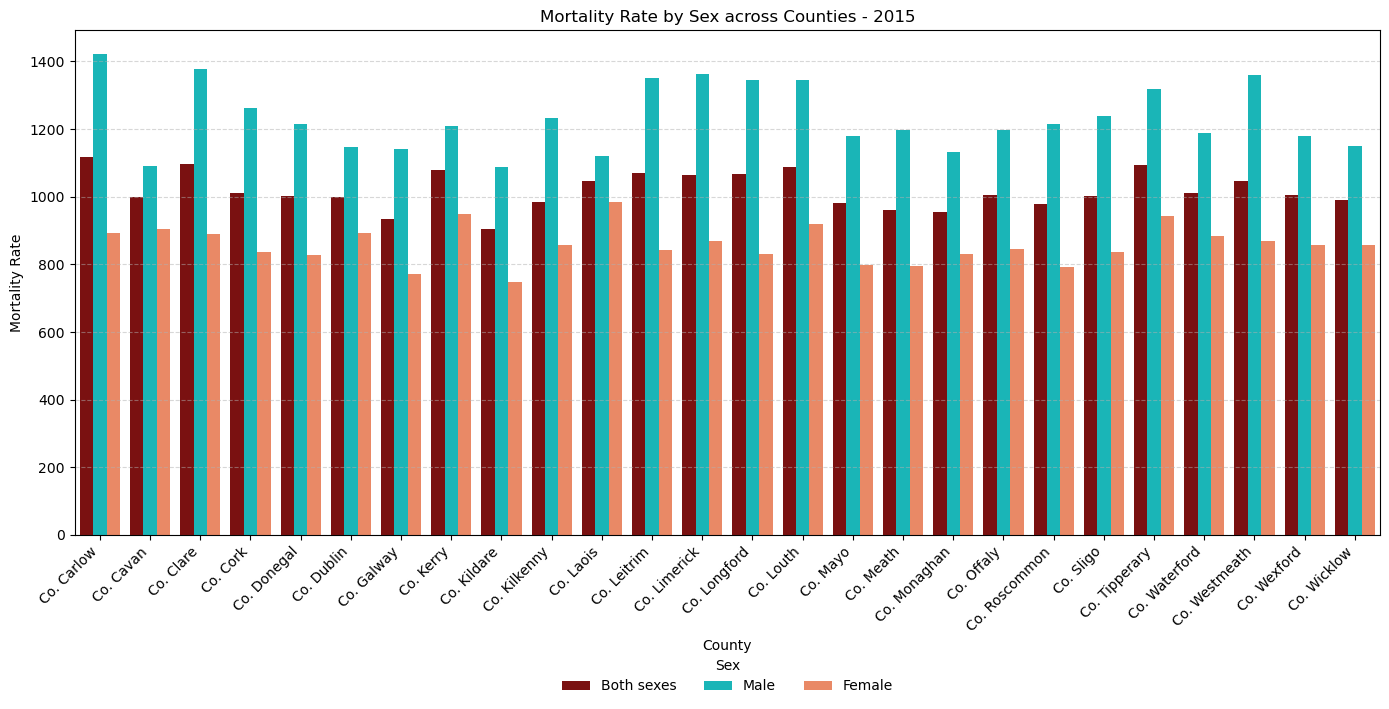

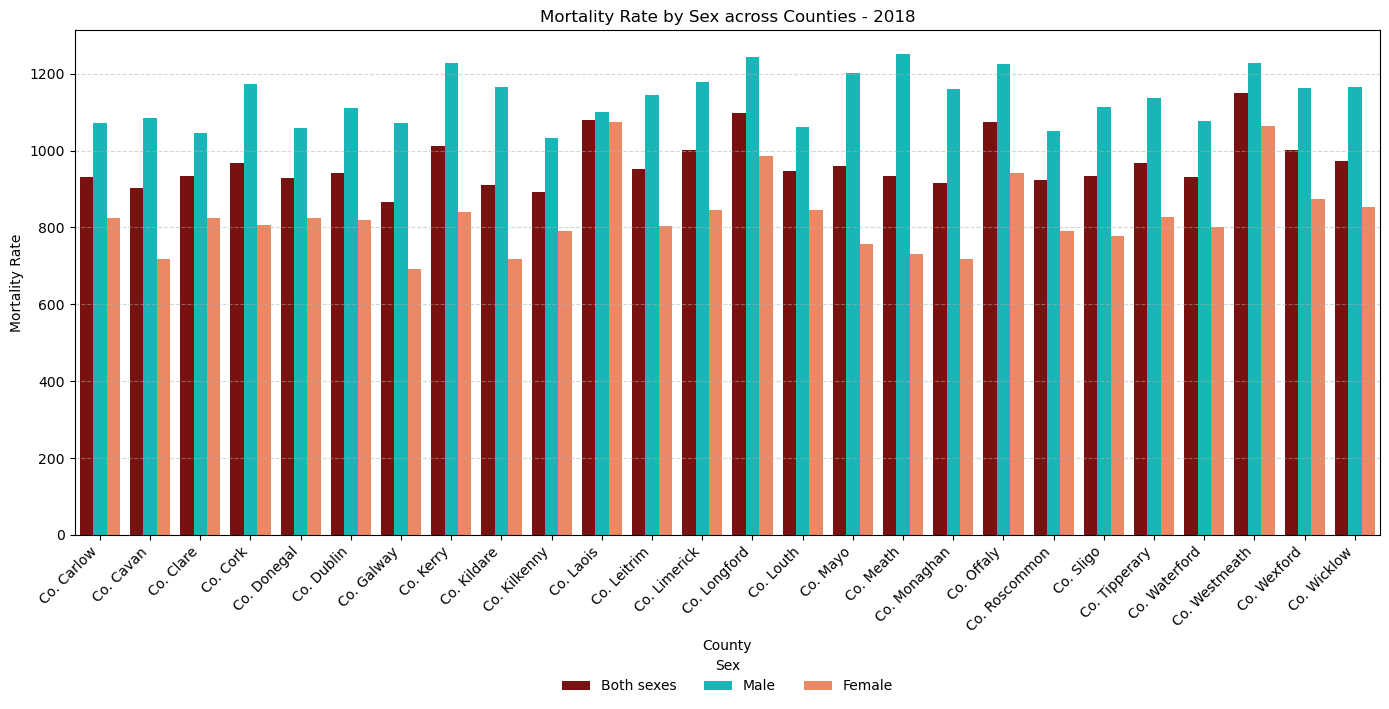

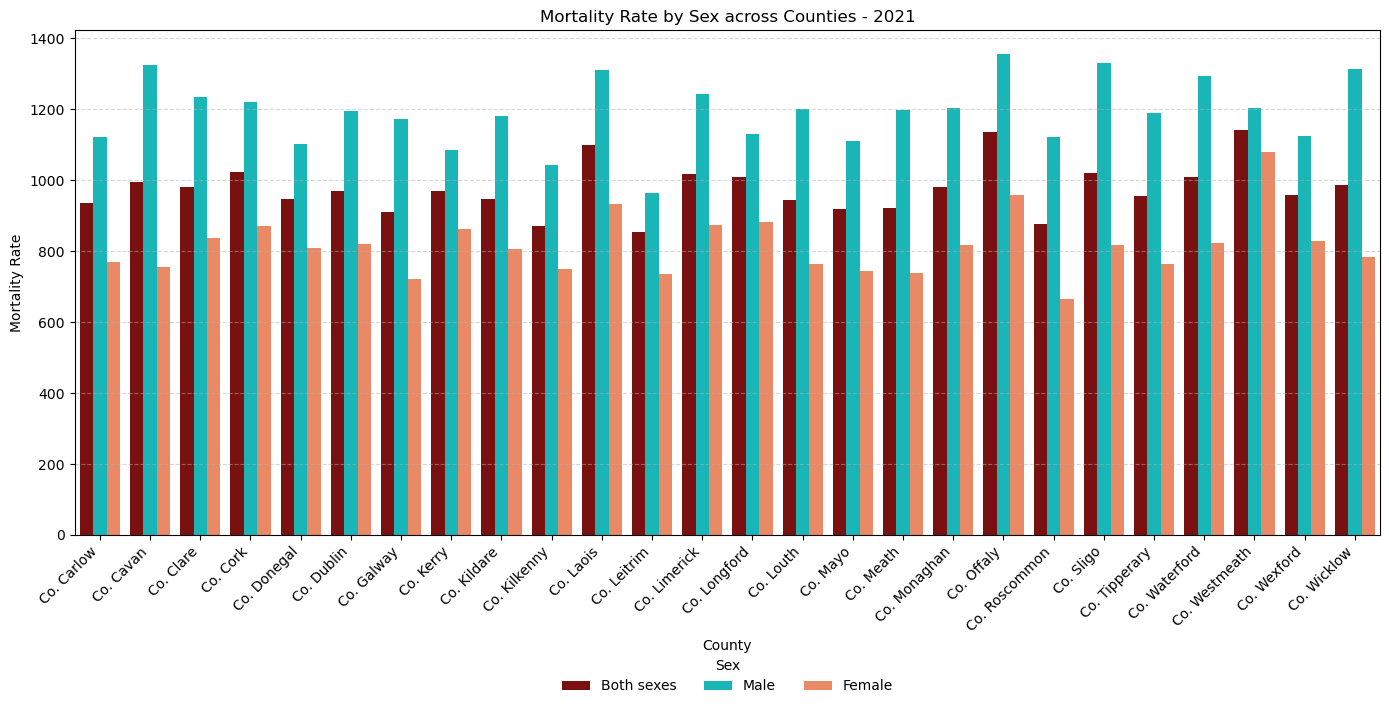

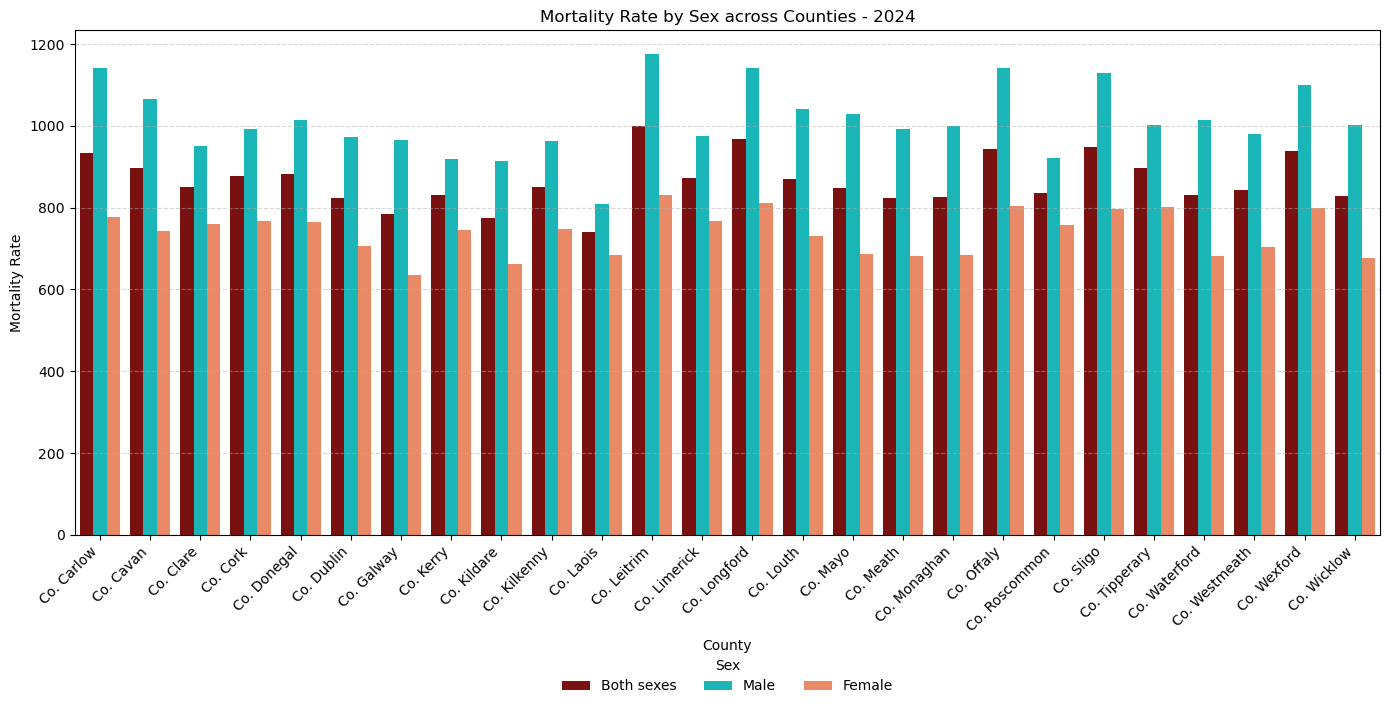

In [13]:
# Finally, we call on our function, defining the year we want. In this case, I've found it more relevant to check the value every 3 years.
plot_grouped_bar_by_sex(regional_data, 2015)
plot_grouped_bar_by_sex(regional_data, 2018)
plot_grouped_bar_by_sex(regional_data, 2021)
plot_grouped_bar_by_sex(regional_data, 2024)

This shows us very clearly the different values across counties. Once more, we can see how Covid-19 increased the deaths by 2021 as the values in the y label, went up to 1400. However, we can see that there's a clear down trend happening across all counties; even though some counties continuing to have very high deaths. 
> 
The other thing we wanted to measure would be the ages. Since we have two values here (working and retired), we'll need something that helps us visualise this easily across time and even counties. Once more, barplots would be helpful here. I researched14 a lot on how to best show this but I was continously having a hard time finding the best plot for this. After some back and forth with ChatGPT15 and even trying out scatterplots and clustered barplots, I decided to stay with the basic barplots. However, we can try and make it better looking by using stacked barplots.16

In [9]:
# Once more, we'll try and make this a function so that we're able to call on it for the years we want.
# Since we're unable to do this in Seaborn, we have to turn to Matplotlib itself to achieve this.

def plot_stacked_bar_by_sex_for_age(data, year, age_group):

    # We filter our data once more. I decided to keep this inside the function this time since we're using matplotlib exclusively 
    # for this and it prevents problems
    df_year = data[
        (data["County"] != "Ireland") &
        (data["Sex"].isin(["Male", "Female"])) &
        (data["Cause of Death"] == "All causes of death") &
        (data["Year"] == year) &
        (data["Age Group"] == age_group)
    # We make sure we get this data and create a dataframe from it via the copy function from Pandas.    
    ].copy()

    # We create a pivot table to organise the data correctly. In this case, we make sure to sum up all male and female values
    # and we separate them by county. This visualisation helps with the stacked barplot.
    stacked_df = (
        df_year.pivot_table(index="County", columns="Sex", values="VALUE", aggfunc="sum")
    )

    # This is where matplotlib comes in. We plot it, following the format outlined in our references. The pandas documentation also
    # helps with additional criteria.
    ax = stacked_df.plot(
        kind="bar",
        stacked=True,
        figsize=(14, 6),
        color=["darkturquoise", "coral"]
    )

    # We keep our legend structure, modifying as needed for this dataset.
    ax.set_title(f"Mortality Rate by Sex across counties — {age_group} — {year}")
    ax.set_xlabel("County")
    ax.set_ylabel("Mortality Rate")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.grid(True, axis="y", linestyle="--", alpha=0.5)

    # Once again we force the legend to the bottom of the plot for clarity.
    ax.legend(
        title="Sex",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.22),
        ncol=2,
        frameon=False
    )

    # We display it.
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.10)
    plt.show()

# References:
# https://www.w3schools.com/python/pandas/ref_df_copy.asp - On the Pandas copy function

# On Stacked Barplots:
# https://www.geeksforgeeks.org/python/create-a-stacked-bar-plot-in-matplotlib/
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html


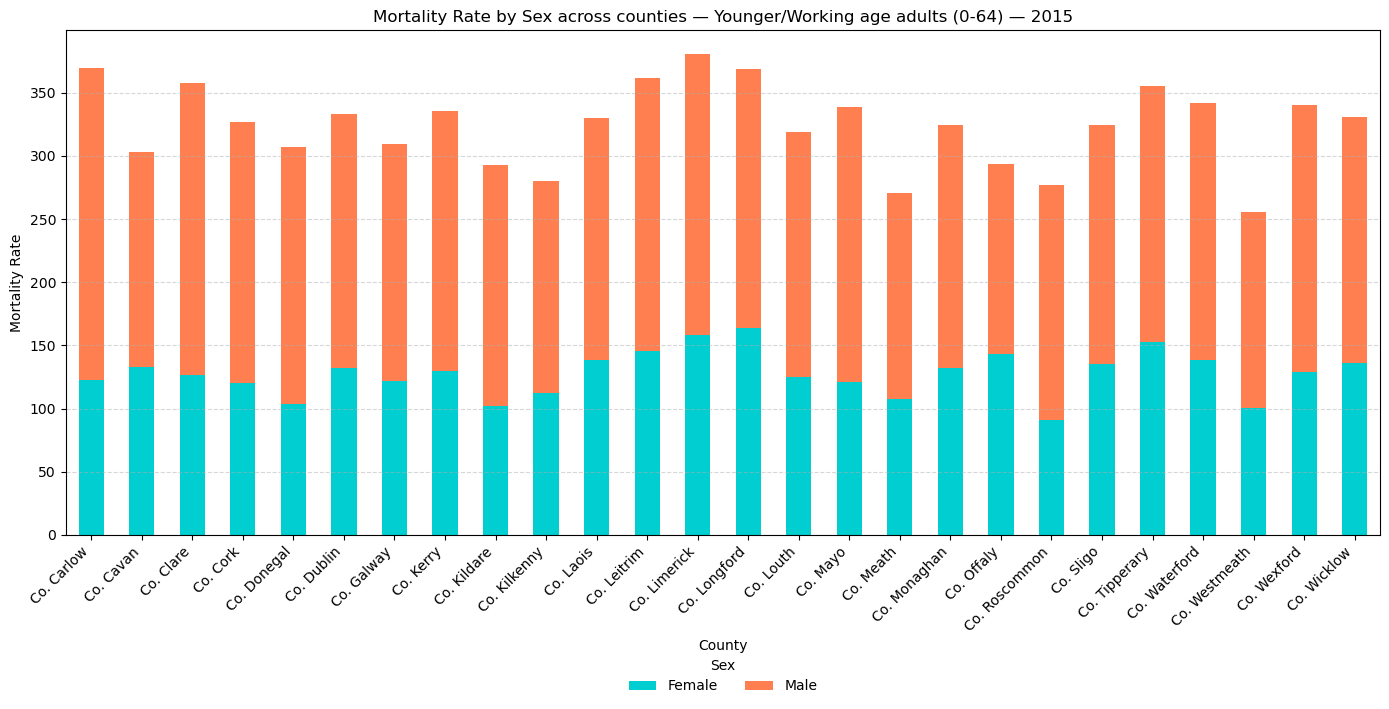

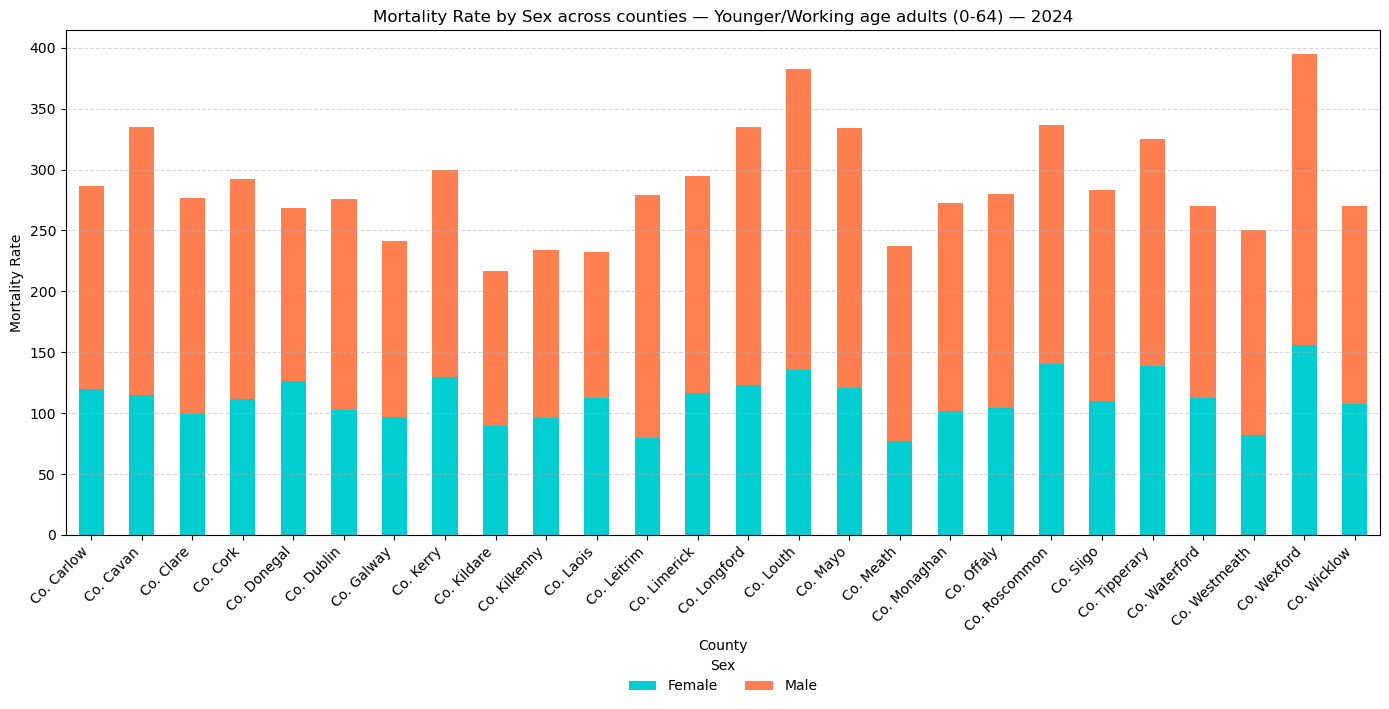

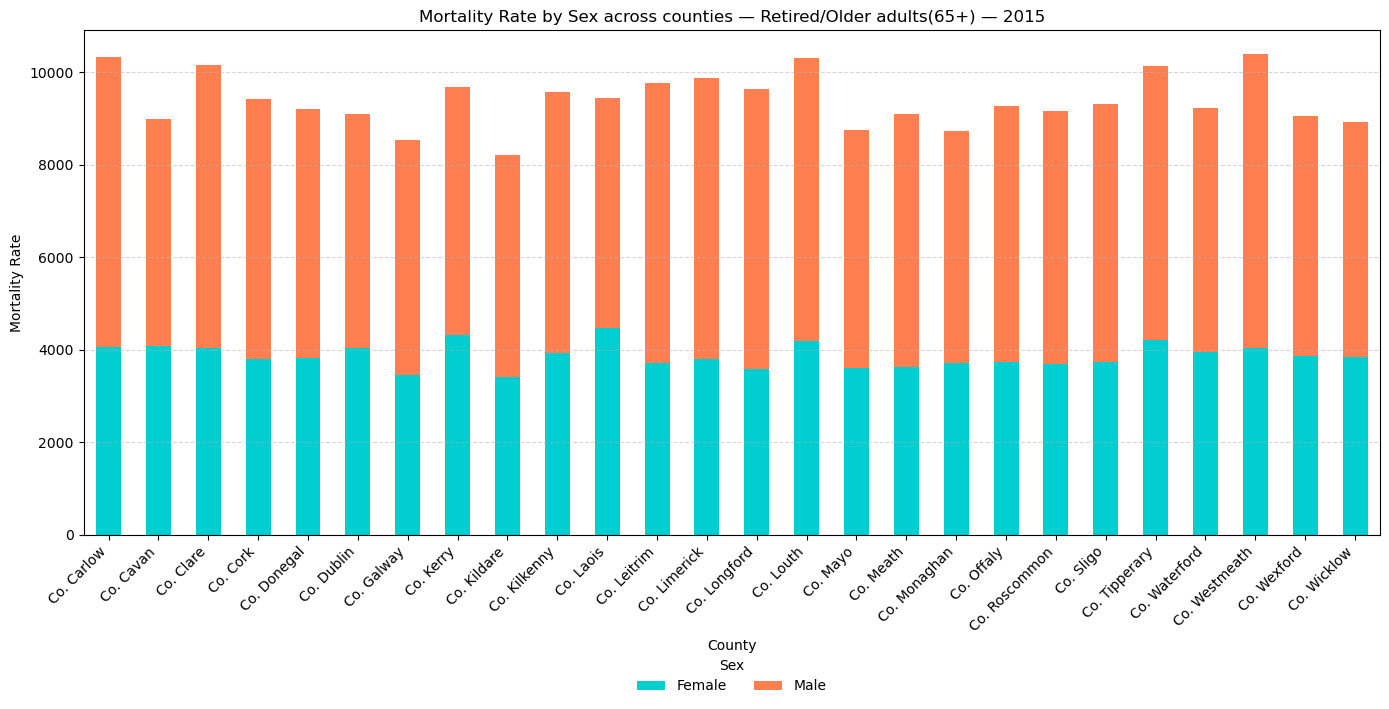

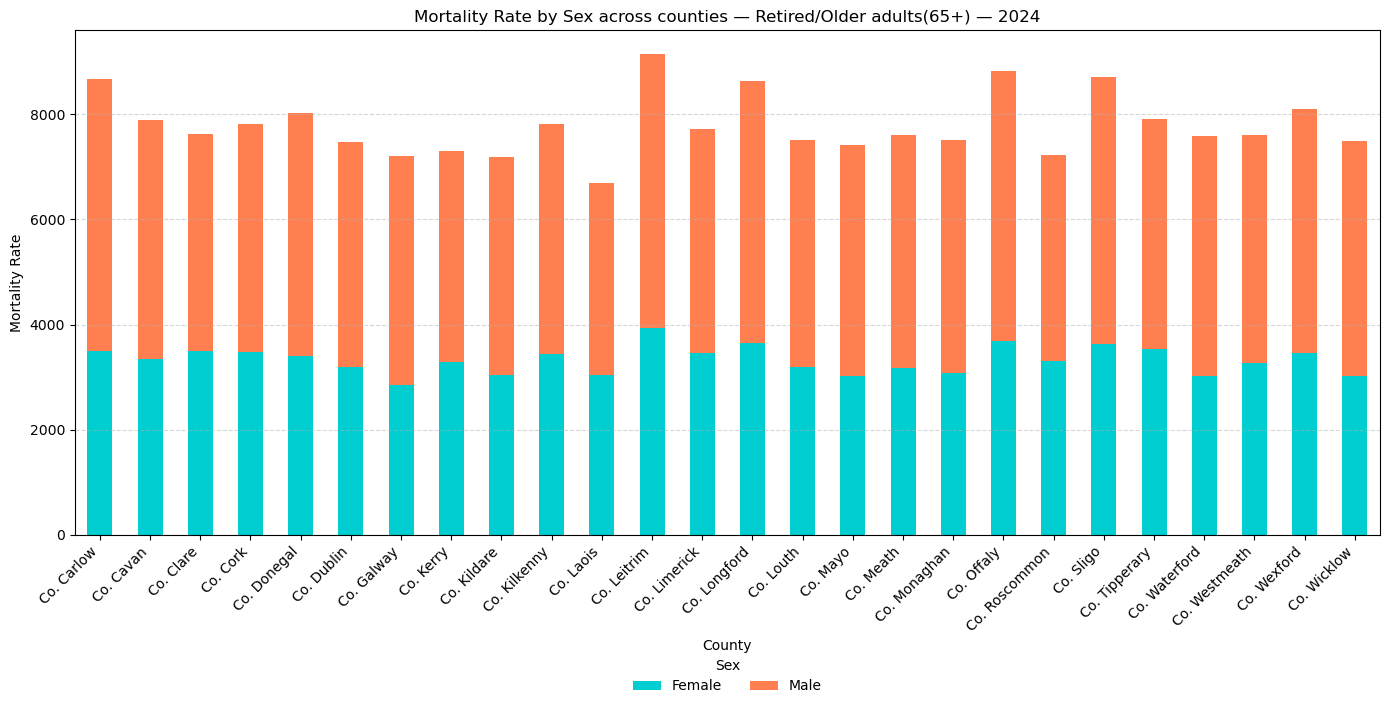

In [10]:
# Finally, we call the function above. 
plot_stacked_bar_by_sex_for_age(
    df,
    2015,
    "Younger/Working age adults (0-64)"
)

plot_stacked_bar_by_sex_for_age(
    df,
    2024,
    "Younger/Working age adults (0-64)"
)

plot_stacked_bar_by_sex_for_age(
    df,
    2015,
    "Retired/Older adults(65+)"
)

plot_stacked_bar_by_sex_for_age(
    df,
    2024,
    "Retired/Older adults(65+)"
)


To prevent repetition, it's best to get the plots for both age groups for 2015 and 2024 specifically, since it allows us to see how much the numbers have changed (or not) in over 9 years.
>
The average checks out but as expected. Retired/Older Adults (65+) have a predominatly higher mortality rate than working age adults. This is normal, if we account for normal life expectancy and natural death. It's also interesting to notice how certain counties actually have higher male deaths at 65+ age in 2024, then 2015. The cause for this is not certain.

### 2.5 Causes of death

The last piece of data we're going to get here would be the causes of death and for this, we would be interested in looking at the causes of death across all spectrums (age, sex and counties).
>
The difficulty here lies in the fact that we have multiple causes of death, to the point where any type of plotting will be cluttered and difficult to read. As such, I decided to divide the causes of death into broad categories. For this, I went ahead and researched the ICD classification and how they do it17 and tried organising into these specific buckets. After some back and forth with ChatGPT18, we arrived at this organisation:
>
- Infectious & parasitic (incl. Covid-19)
- Neoplasms (all cancers)
- Endocrine, nutritional & metabolic
- Mental, behavioural & substance use
- Nervous system & sense organs
- Circulatory diseases
- Respiratory diseases
- Digestive & liver diseases
- Genitourinary diseases
- Other specified non-communicable (blood, skin, musculoskeletal)
- Maternal, perinatal, congenital & SIDS
- External causes of injury & poisoning
- Ill-defined & unknown causes
>
ChatGPT suggested that smoking and alchohol causes be removed because they overlap with other conditions. Some of which, we're not really sure if they are actually caused by smoking *(e.g. Smoking causes lung cancer - Smoking is not the mortality cause, lung cancer is)*. I also chose to keep Meningitis in the **Infectious & parasitic (incl. Covid-19)** bucket since it's technically a viral/bacterial infection. 

With the following done, we can move on to the code and for this, the first thing we need to do is create dictionaries for these diseases that can house the categories we defined.

In [11]:
cause_bucket_map = {
    # 1. Infectious & parasitic (incl. Covid-19)
    "Infectious and parasitic diseases": "Infectious & parasitic (incl. Covid-19)",
    "Tuberculosis": "Infectious & parasitic (incl. Covid-19)",
    "Meningococcal infection": "Infectious & parasitic (incl. Covid-19)",
    "Aids (HIV disease)": "Infectious & parasitic (incl. Covid-19)",
    "Viral hepatitis": "Infectious & parasitic (incl. Covid-19)",
    "Covid-19, virus identified and virus unidentified": "Infectious & parasitic (incl. Covid-19)",
    "Meningitis": "Infectious & parasitic (incl. Covid-19)", 

    # 2. Neoplasms (all cancers)
    "Neoplasms": "Neoplasms (all cancers)",
    "Malignant neoplasms": "Neoplasms (all cancers)",
    "Malignant neoplasm of lip, oral cavity, pharynx": "Neoplasms (all cancers)",
    "Malignant neoplasm of oesphagus": "Neoplasms (all cancers)",
    "Malignant neoplasm of stomach": "Neoplasms (all cancers)",
    "Malignant neoplasm of colon": "Neoplasms (all cancers)",
    "Malignant neoplasm of rectum and anus": "Neoplasms (all cancers)",
    "Malignant neoplasm of liver and the intrahepatic bile ducts": "Neoplasms (all cancers)",
    "Malignant neoplasm of pancreas": "Neoplasms (all cancers)",
    "Malignant neoplasm of larynx and trachea/bronchus/lung": "Neoplasms (all cancers)",
    "Malignant neoplasm of skin": "Neoplasms (all cancers)",
    "Malignant neoplasm of breast": "Neoplasms (all cancers)",
    "Malignant neoplasm of cervix uteri": "Neoplasms (all cancers)",
    "Malignant neoplasm of other parts of the uterus": "Neoplasms (all cancers)",
    "Malignant neoplasm of ovary": "Neoplasms (all cancers)",
    "Malignant neoplasm of prostate": "Neoplasms (all cancers)",
    "Malignant neoplasm of kidney": "Neoplasms (all cancers)",
    "Malignant neoplasm of bladder": "Neoplasms (all cancers)",
    "Malignant neoplasm of lymph/haematopoietic tissue": "Neoplasms (all cancers)",

    # 3. Endocrine, nutritional & metabolic
    "Endocrine, nutritional and metabolic diseases": "Endocrine, nutritional & metabolic",
    "Diabetes mellitus": "Endocrine, nutritional & metabolic",

    # 4. Mental, behavioural & substance use
    "Mental and behavioural disorders": "Mental, behavioural & substance use",
    "Alcohol abuse (including alcoholic psychosis)": "Mental, behavioural & substance use",
    "Drug dependance, toxicomania": "Mental, behavioural & substance use",

    # 5. Nervous system & sense organs
    "Diseases of the nervous system and the sense organs": "Nervous system & sense organs",

    # 6. Circulatory diseases
    "Diseases of the circulatory system": "Circulatory diseases",
    "Ischaemic heart disease": "Circulatory diseases",
    "Other heart disease": "Circulatory diseases",
    "Cerebrovascular disease": "Circulatory diseases",

    # 7. Respiratory diseases
    "Diseases of the respiratory system": "Respiratory diseases",
    "Influenza": "Respiratory diseases",
    "Pneumonia": "Respiratory diseases",
    "Chronic lower respiratory disease": "Respiratory diseases",
    "Asthma": "Respiratory diseases",

    # 8. Digestive & liver diseases
    "Diseases of the digestive system": "Digestive & liver diseases",
    "Ulcer of stomach, duodenum and jejunum": "Digestive & liver diseases",
    "Chronic liver disease": "Digestive & liver diseases",

    # 9. Genitourinary diseases
    "Diseases of the genitourinary system": "Genitourinary diseases",
    "Diseases of the kidney and ureter": "Genitourinary diseases",

    # 10. Other specified non-communicable (blood, skin, musculoskeletal)
    "Diseases of the blood and blood-forming organs, immunulogical disorders":
        "Other specified non-communicable",
    "Diseases of the skin and subcutaneous tissue": "Other specified non-communicable",
    "Diseases of the musculoskeletal system/connective tissue": "Other specified non-communicable",
    "Rheumatoid arthritis and osteoarthrosis": "Other specified non-communicable",

    # 11. Maternal, perinatal, congenital & SIDS
    "Complications of pregnancy, childbirth and puerperium": "Maternal, perinatal, congenital & SIDS",
    "Certain conditions originating in the perinatal period (excluding stillbirths)":
        "Maternal, perinatal, congenital & SIDS",
    "Congenital malformations and chromosomal abnormalities": "Maternal, perinatal, congenital & SIDS",
    "Congenital malformations of the nervous system": "Maternal, perinatal, congenital & SIDS",
    "Congenital malformations of the circulatory system": "Maternal, perinatal, congenital & SIDS",
    "Sudden infant death syndrome": "Maternal, perinatal, congenital & SIDS",

    # 12. External causes of injury & poisoning
    "External causes of injury and poisoning": "External causes of injury & poisoning",
    "Accidents": "External causes of injury & poisoning",
    "Transport accidents": "External causes of injury & poisoning",
    "Accidental falls": "External causes of injury & poisoning",
    "Accidental poisoning": "External causes of injury & poisoning",
    "Suicide and intentional self harm": "External causes of injury & poisoning",
    "Homicide/assault": "External causes of injury & poisoning",
    "Event of undetermined intent": "External causes of injury & poisoning",

    # 13. Ill-defined & unknown
    "Symptoms, signs, abnormal findings, ill-defined causes": "Ill-defined & unknown",
    "Unknown and unspecified causes": "Ill-defined & unknown",

    # Special categories 
    # total, no use in keeping
    "All causes of death": None, 

    # Removing this as mentioned
    "Selected alcohol related causes": None,  
    "Selected smoking related causes": None,  
}

# We then add this dictionary to our dataframe in the form of a column and map our cause bucket to our causes of death with the .map function.
df["Cause Bucket"] = df["Cause of Death"].map(cause_bucket_map)
df

# References: 
# https://chatgpt.com/share/694597d9-6330-800b-b5f9-b4652f2c947a - On the Dictionary organisation and the code for adding another column to the Dataframe

Year         Sex       County                          Age Group  \
0       2015  Both sexes      Ireland  Younger/Working age adults (0-64)   
1       2015  Both sexes      Ireland  Younger/Working age adults (0-64)   
2       2015  Both sexes      Ireland  Younger/Working age adults (0-64)   
3       2015  Both sexes      Ireland  Younger/Working age adults (0-64)   
4       2015  Both sexes      Ireland  Younger/Working age adults (0-64)   
...      ...         ...          ...                                ...   
167665  2024      Female  Co. Wexford                           All ages   
167666  2024      Female  Co. Wexford                           All ages   
167667  2024      Female  Co. Wexford                           All ages   
167668  2024      Female  Co. Wexford                           All ages   
167669  2024      Female  Co. Wexford                           All ages   

                                           Cause of Death   VALUE  \
0                                     All causes of death  161.63   
1                       Infectious and parasitic diseases    1.75   
2                                            Tuberculosis    0.15   
3                                 Meningococcal infection    0.04   
4                                      Aids (HIV disease)    0.19   
...                                                   ...     ...   
167665                                   Homicide/assault    0.00   
167666                       Event of undetermined intent    0.00   
167667  Covid-19, virus identified and virus unidentified   13.26   
167668                    Selected alcohol related causes   15.54   
167669                    Selected smoking related causes  279.17   

                                   Cause Bucket  
0                                          None  
1       Infectious & parasitic (incl. Covid-19)  
2       Infectious & parasitic (incl. Covid-19)  
3       Infectious & parasitic (incl. Covid-19)  
4       Infectious & parasitic (incl. Covid-19)  
...                                         ...  
167665    External causes of injury & poisoning  
167666    External causes of injury & poisoning  
167667  Infectious & parasitic (incl. Covid-19)  
167668                                     None  
167669                                     None  

[167670 rows x 7 columns]

#### 2.5.1 National overview (All ages, All Ireland, Both sexes):

- Regional snapshot:

With the above done, we can start plotting and looking at the National Overview. For a horizontal lineplot, we can follow the same structure as before.

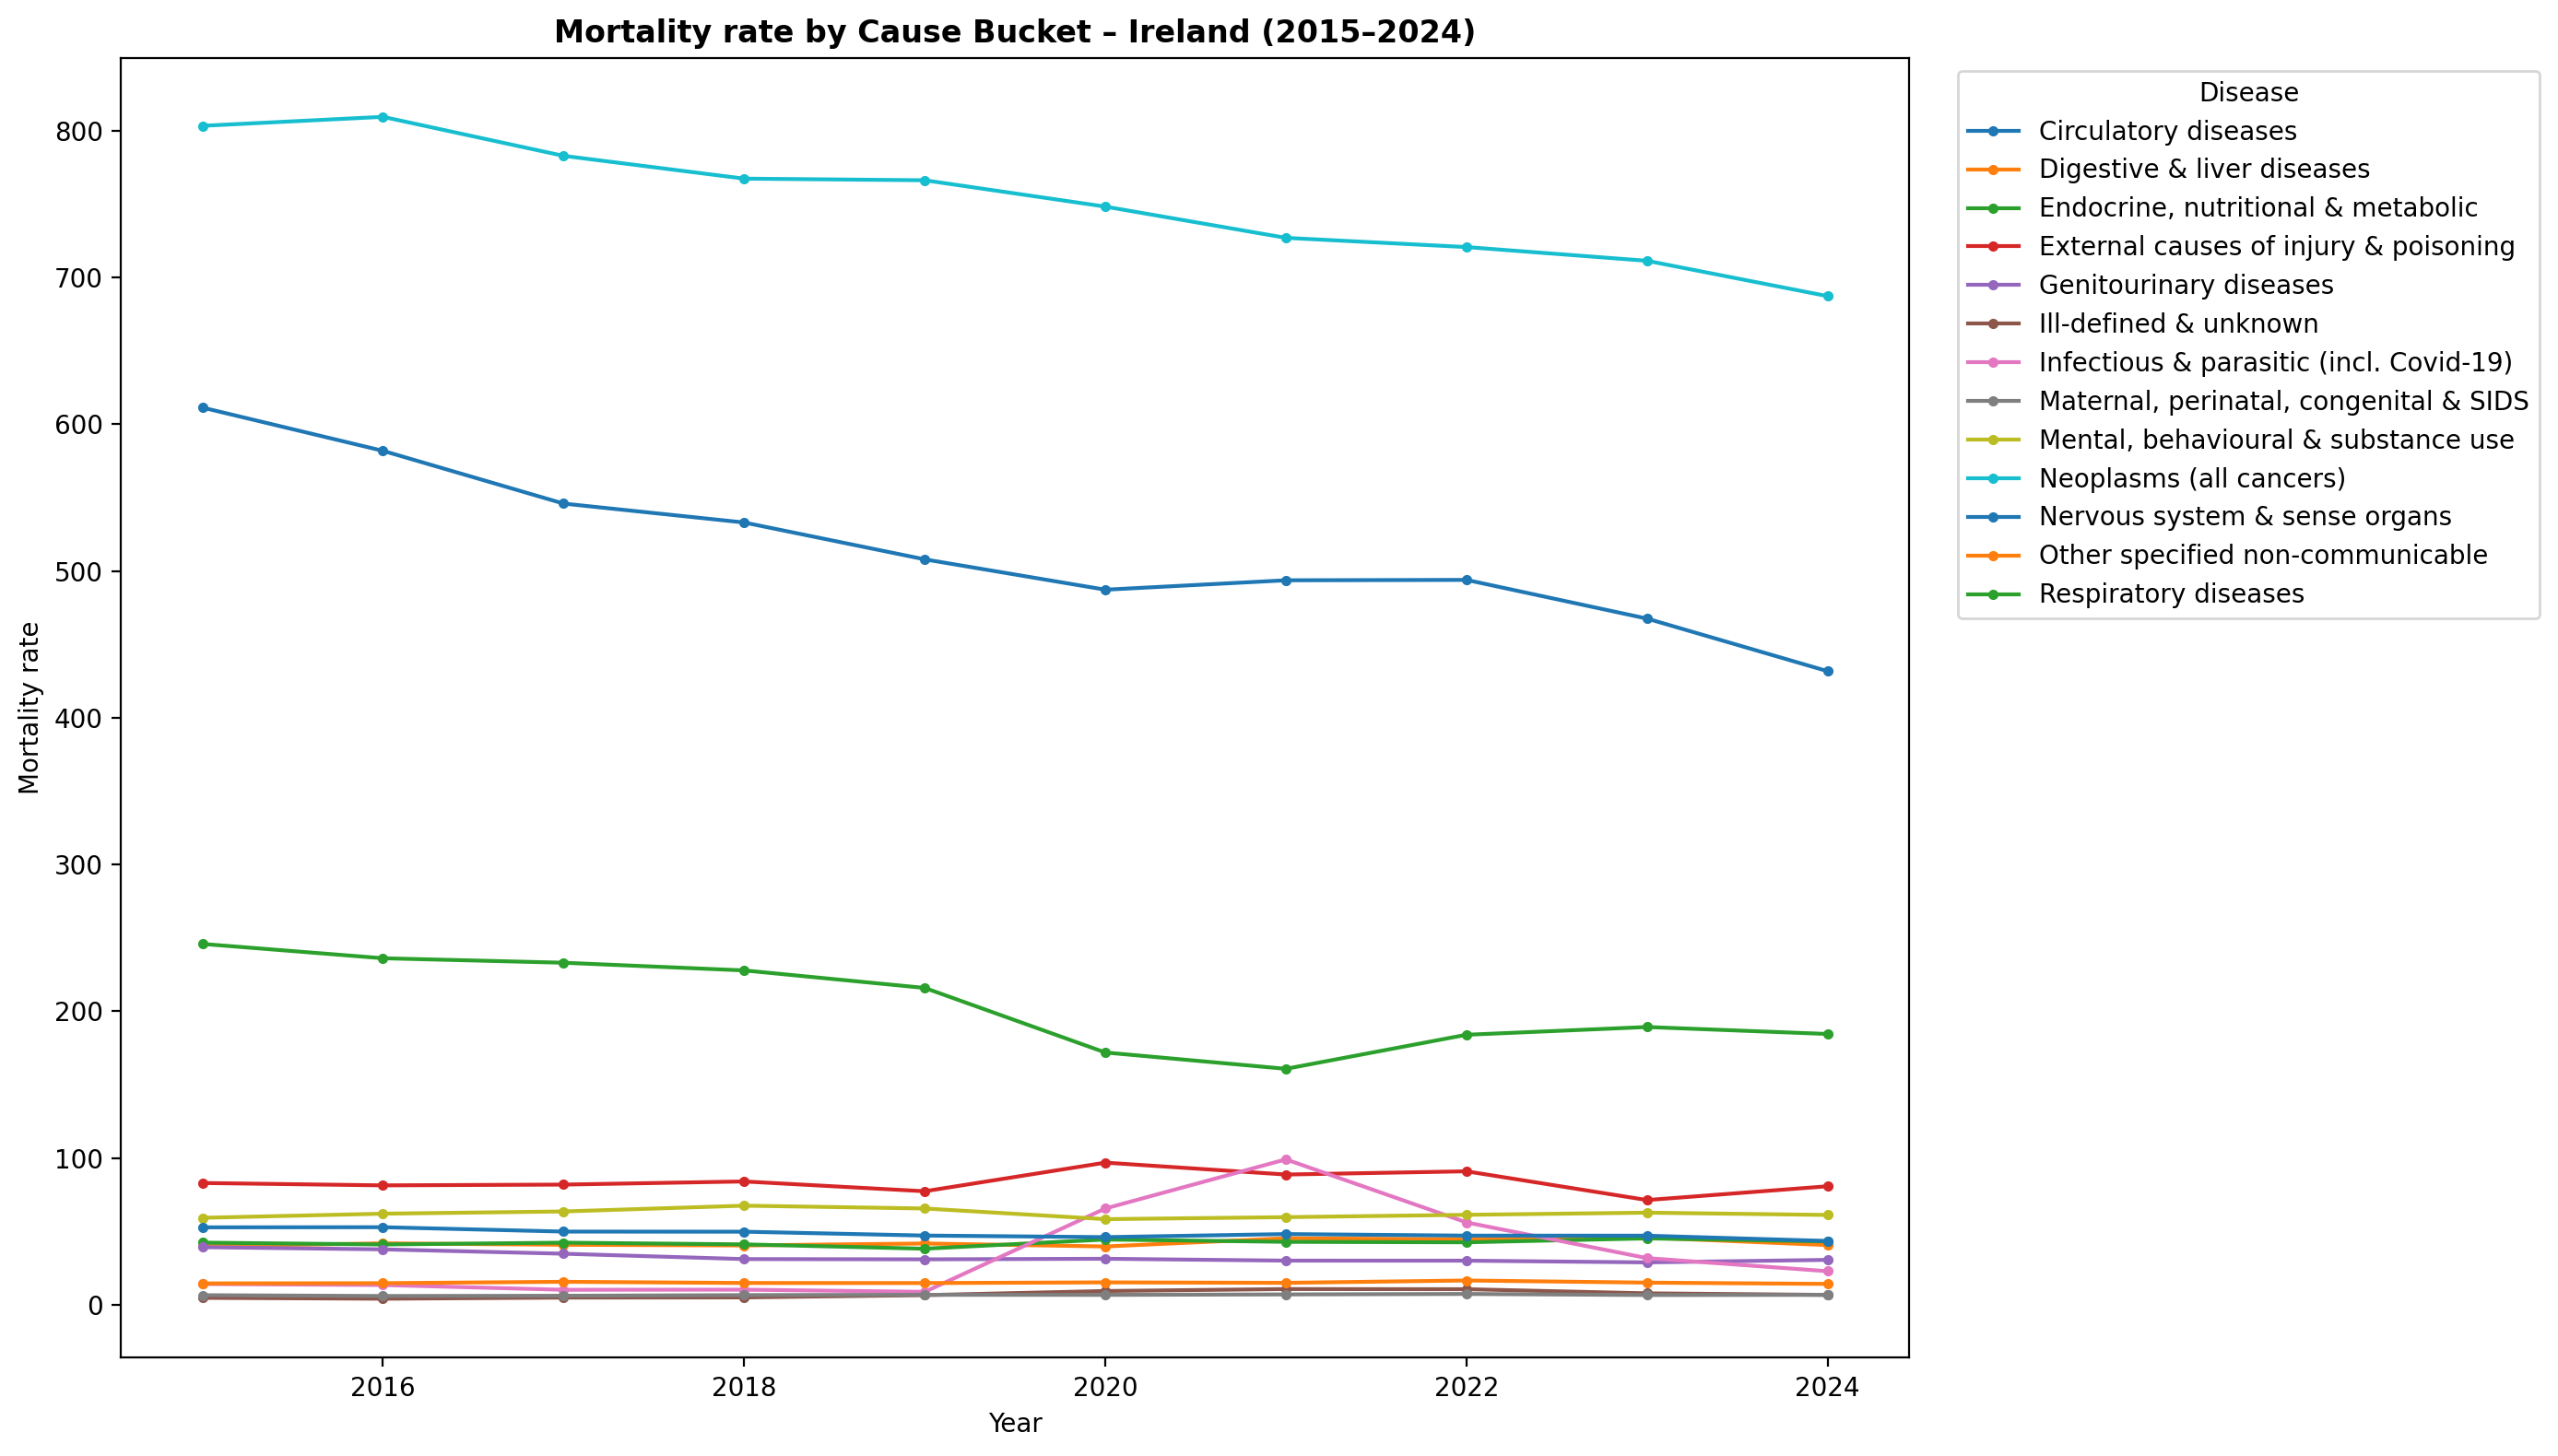

In [12]:
# We filter once again, making sure to include all ages, sexes and counties.
national_cause_buckets = df[
    (df['County'] == 'Ireland') &
    (df['Sex'] == 'Both sexes') &
    (df['Age Group'] == 'All ages') &
# This makes sure the Nones we defined don't show up. 
    (df['Cause Bucket'].notna())
]

# 2. We group our buckets by year as a timeseries. I was getting an error saying: 
# TypeError: Series.sort_values() takes 1 positional argument but 2 were given
# Thanks to ChatGPT, had to add as_index=False to the code to make sure it's a dataframe.
bucket_by_year = (
    national_cause_buckets
    .groupby(['Year', 'Cause Bucket'],as_index=False)['VALUE']
    .sum()
    .sort_values(['Cause Bucket', 'Year'])
)

# We make our plot and measurements
fig, ax = plt.subplots(figsize=(14, 8), dpi=200)

# Same logic as we did for the sexes, only this time we're making for each disease.
for bucket, disease in bucket_by_year.groupby('Cause Bucket'):
    ax.plot(
        disease['Year'],
        disease['VALUE'],
        marker='.',
        label=bucket
    )

# Rest of the code stays the same, only adapted for this specific plot.
ax.set_xlabel('Year')
ax.set_ylabel('Mortality rate')
ax.set_title('Mortality rate by Cause Bucket – Ireland (2015–2024)', fontweight='bold')

ax.legend(
    title='Disease',
    loc='upper left',
    bbox_to_anchor=(1.02, 1.0)
)

fig.tight_layout()
plt.show()

# References: 
# https://chatgpt.com/share/694a8f57-484c-800b-a817-d1c74b956957
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html



As we can see, most of the deseases are currently going down. We had a slight spike between 2019 and 2022 for infectious and parasitic, since it's being boosted by Covid-19, which is understandable. 

We can look at top 5 causes of death in 2015 and 2024 to see if anything changed. Once again, we follow the structure we did for our sexes from before.

In [13]:
# First, we're gonna filter this to get our diseases for all ages and sexes
national_cause_data = df[ (df['County'] == 'Ireland') & 
            (df['Sex'] == 'Both sexes') & 
            (df['Age Group'] == 'All ages') & 
            (df['Cause Bucket'].notna()) ].copy()

# Then, we're gonna get the top 5 causes. We group our Cause Bucket by VALUE and sum up those values, from highest to lowest 
# and we assign them to a list to call from.
top_5_causes = (
    national_cause_data
    .groupby("Cause Bucket")["VALUE"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

In [14]:
# Same logic, we make a function to call upon.
def plot_top_5_cause_buckets(data, year, top_5_causes):
    # We filter our dataframe for the specific year and top 5 causes
    df_year = data[
        (data['Year'] == year) & 
        (data['Cause Bucket'].isin(top_5_causes))
    ]

    # Group by cause and sum values making sure it's a dataframe with the as_index=FALSE.
    df_plot = (
        df_year
        .groupby('Cause Bucket', as_index=False)['VALUE']
        .sum()
        # Had to add this in order to get highest to lowest
        .sort_values('VALUE', ascending=False)
    )

    # We make our plot.
    plt.figure(figsize=(10, 6), dpi=200)
    ax = sns.barplot(
        data=df_plot,
        x='VALUE',
        y='Cause Bucket',
        color='crimson'
    )

    # Set appropriate legend and labels.
    ax.set_title(f"Top 5 Causes of Death – Ireland ({year})", fontweight='bold')
    ax.set_xlabel("Mortality Rate")
    ax.set_ylabel("Cause of Death")
    
    plt.tight_layout()
    plt.show()


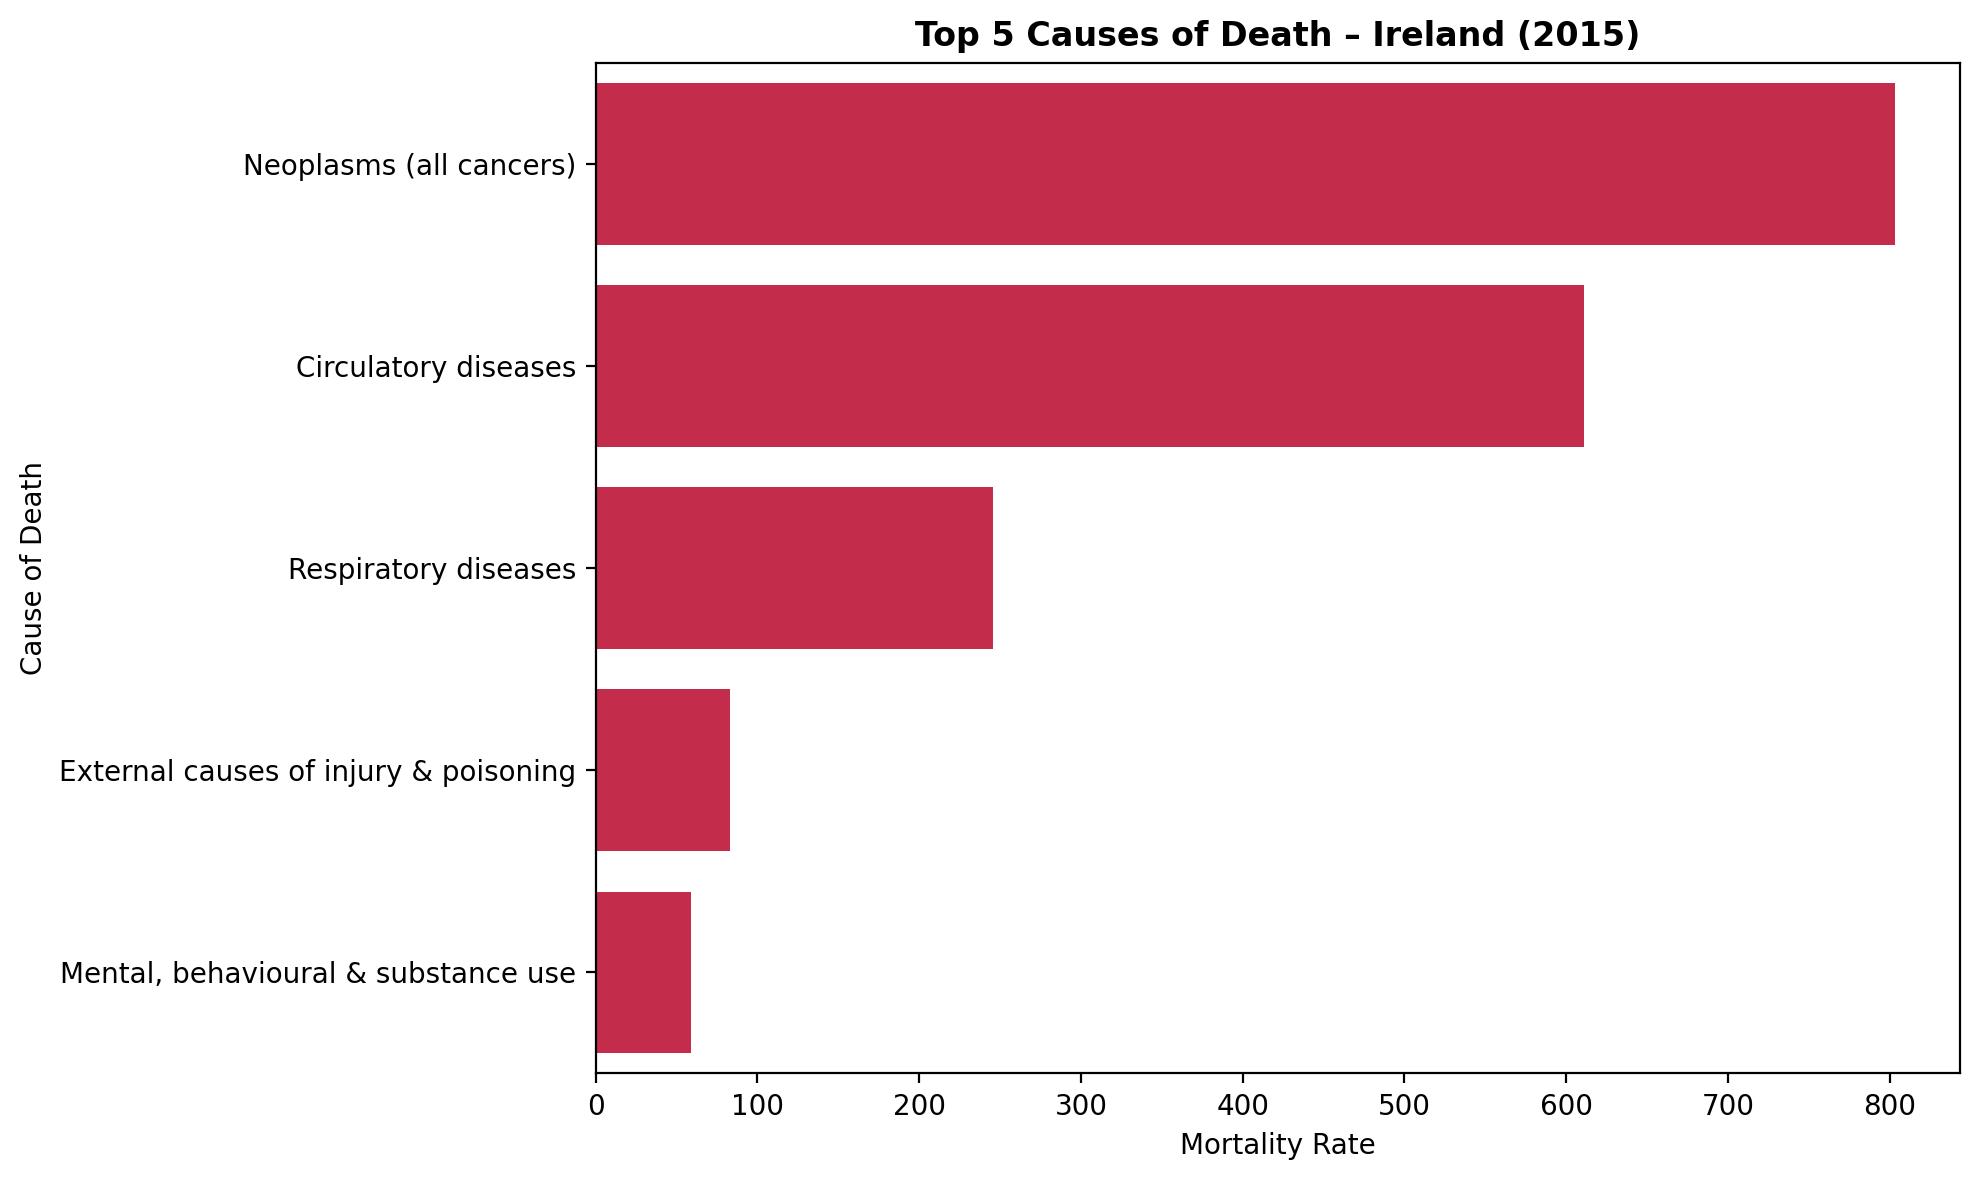

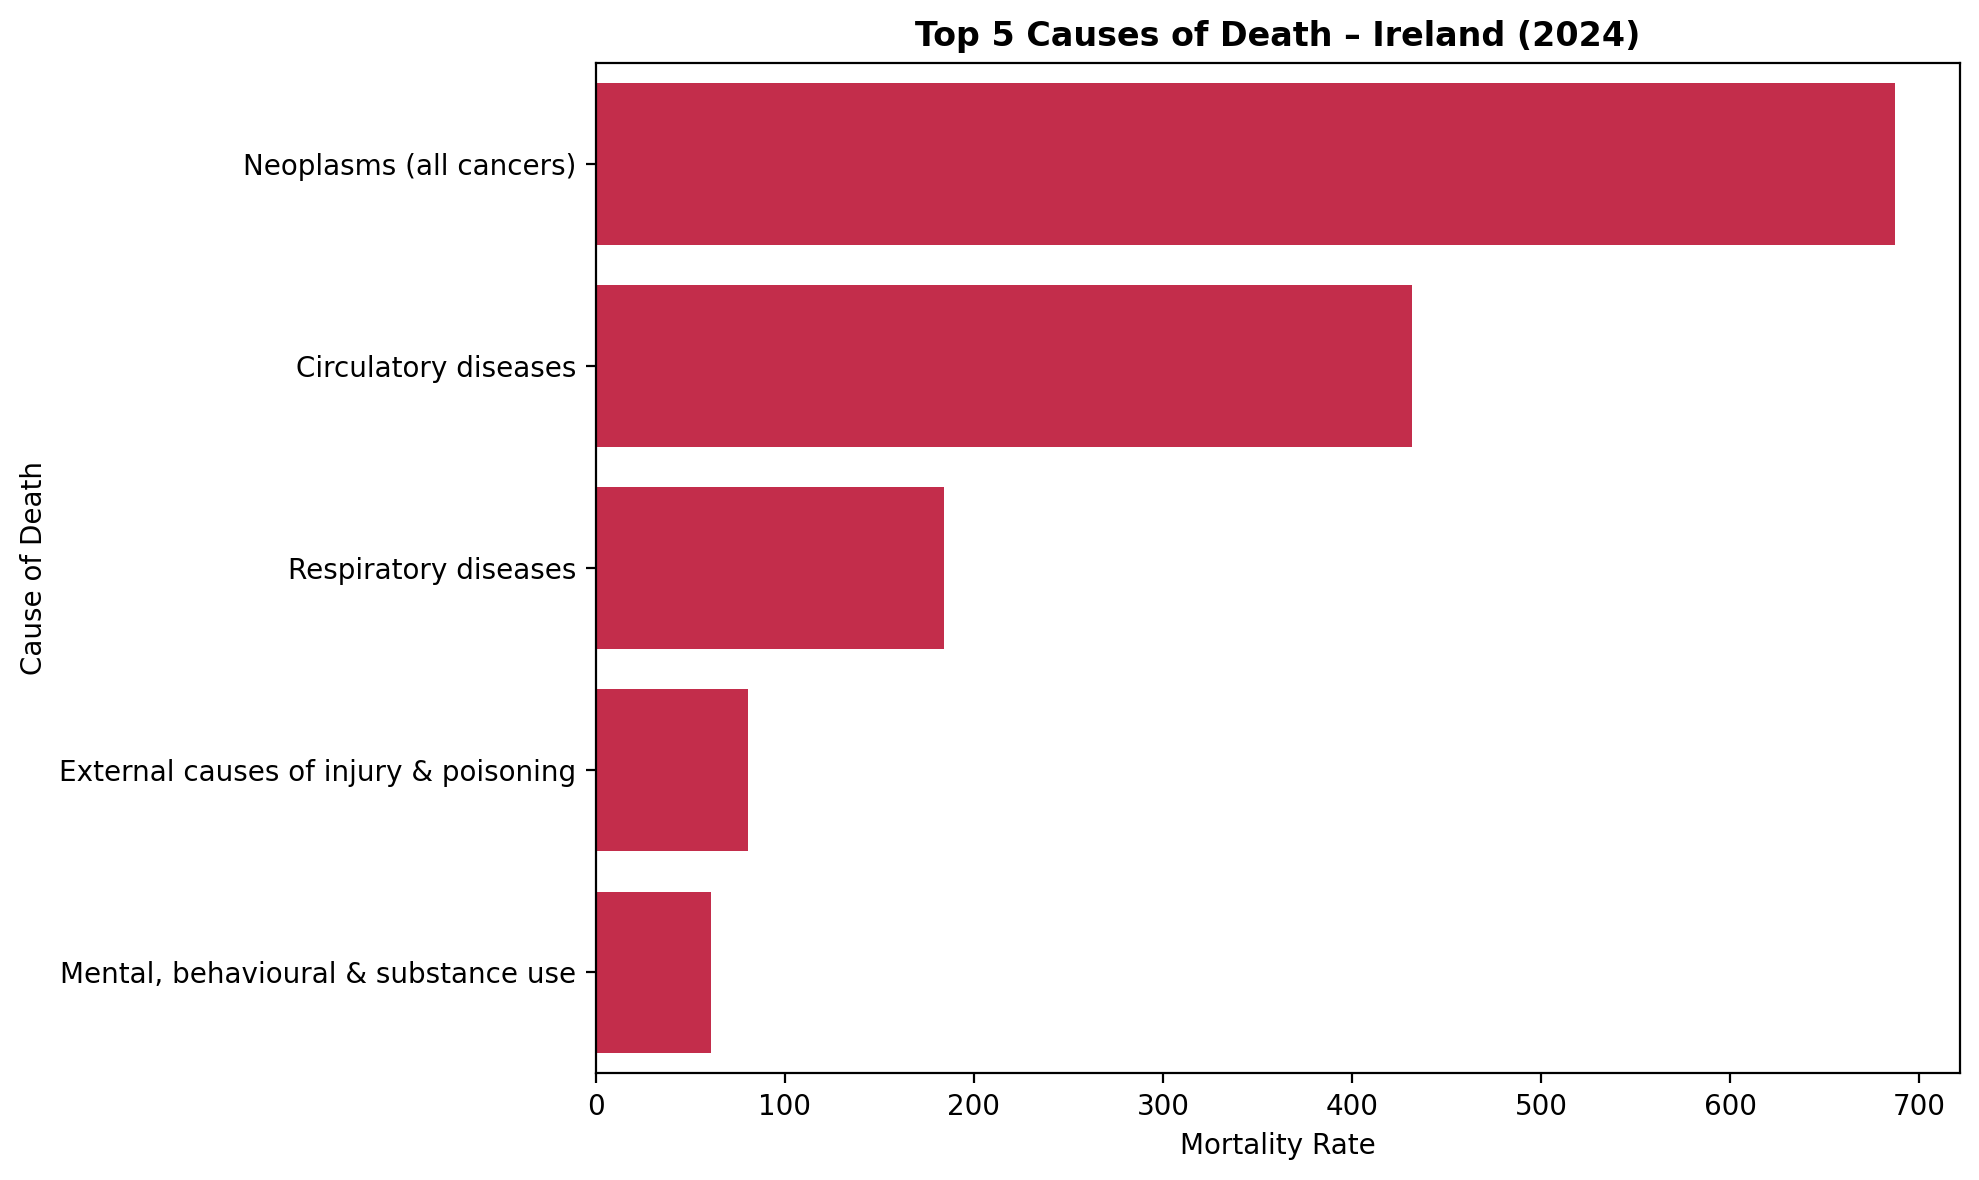

In [15]:
plot_top_5_cause_buckets(national_cause_data, 2015, top_5_causes)
plot_top_5_cause_buckets(national_cause_data, 2024, top_5_causes)

As we can see from our plots here, the top 5 biggest causes of death haven't really changed in 9 years. While there was an overall decrease, as shown by the numbers, it's still the same top 5, with Neoplasms (all cancers) continuing to lead the figures as the top most cause of death across all age and sex groups.

#### 2.5.2 Top 10 Causes of Death (Male and Female):

If we want to see how this is showing for both sexes, we can avail of a Pyramid Plot19, since these are great to help us visualise gender distribution against a set of values. Traditionally it's for age and sex, but we make sure our "y" column contains anything we want. In this case, we can make our "y" values the top 10 causes of death.

In [33]:
def plot_top_5_pyramid(data, year, top_5_causes):
    # Filter for Ireland, all ages, selected year, and top causes same code as before, making sure
    # that male and female values are what we want.
    df_filtered_sex = data[
        (data['County'] == 'Ireland') &
        (data['Age Group'] == 'All ages') &
        (data['Year'] == year) &
        (data['Sex'].isin(['Male', 'Female'])) &
        (data['Cause Bucket'].isin(top_5_causes))
    ]

    # Group by cause and sex, sum the values. I was continously getting errors here with pivot, so I was able 
    # find out about unstack which allowed me to pivot the sex category from the index (which was causing the errors) to columns.
    df_sex_grouped = df_filtered_sex.groupby(['Cause Bucket', 'Sex'])['VALUE'].sum().unstack()

    # This helps us sort the pyramid. This was incredibly difficult to do correctly and I simply was not able to get 
    # the pyramid ordered. After clarifying with ChatGPT, he proposed the following code which helped.
    df_sex_grouped['Total'] = df_sex_grouped['Male'] + df_sex_grouped['Female']
    df_sex_grouped = df_sex_grouped.sort_values('Total', ascending=True)
    df_sex_grouped.drop(columns='Total', inplace=True)

    # This grabs all of our causes that are already sorted in the index and makes them a list that we can use 
    # for plotting.
    causes = df_sex_grouped.index.tolist()

    # We make the female values go left, into the negative by adding a "-" sign.
    df_sex_grouped['Female'] = -df_sex_grouped['Female']

    # We create our plot with the .barh function and make sure we get our width, our groups and our labels.
    plt.figure(figsize=(10, 6), dpi=200)
    plt.barh(causes, df_sex_grouped['Male'], label='Male', color="darkturquoise")
    plt.barh(causes, df_sex_grouped['Female'], label='Female', color="coral")

    # We add legends and titles.
    plt.title(f"Top 5 Causes of Death in Ireland by Sex – {year}", fontweight='bold')
    plt.xlabel("Deaths (Male on right, Female on left)")
    plt.ylabel("Cause of Death")
    plt.legend(loc='lower right')


    plt.tight_layout()
    plt.show()

# References:
# https://chatgpt.com/share/694bae75-6d20-800b-a182-3a49559460a6 - On ordering the pyramid

# On using the .unstack function
# https://stackoverflow.com/questions/69139030/why-and-when-should-use-a-stack-and-unstack-methods
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html 



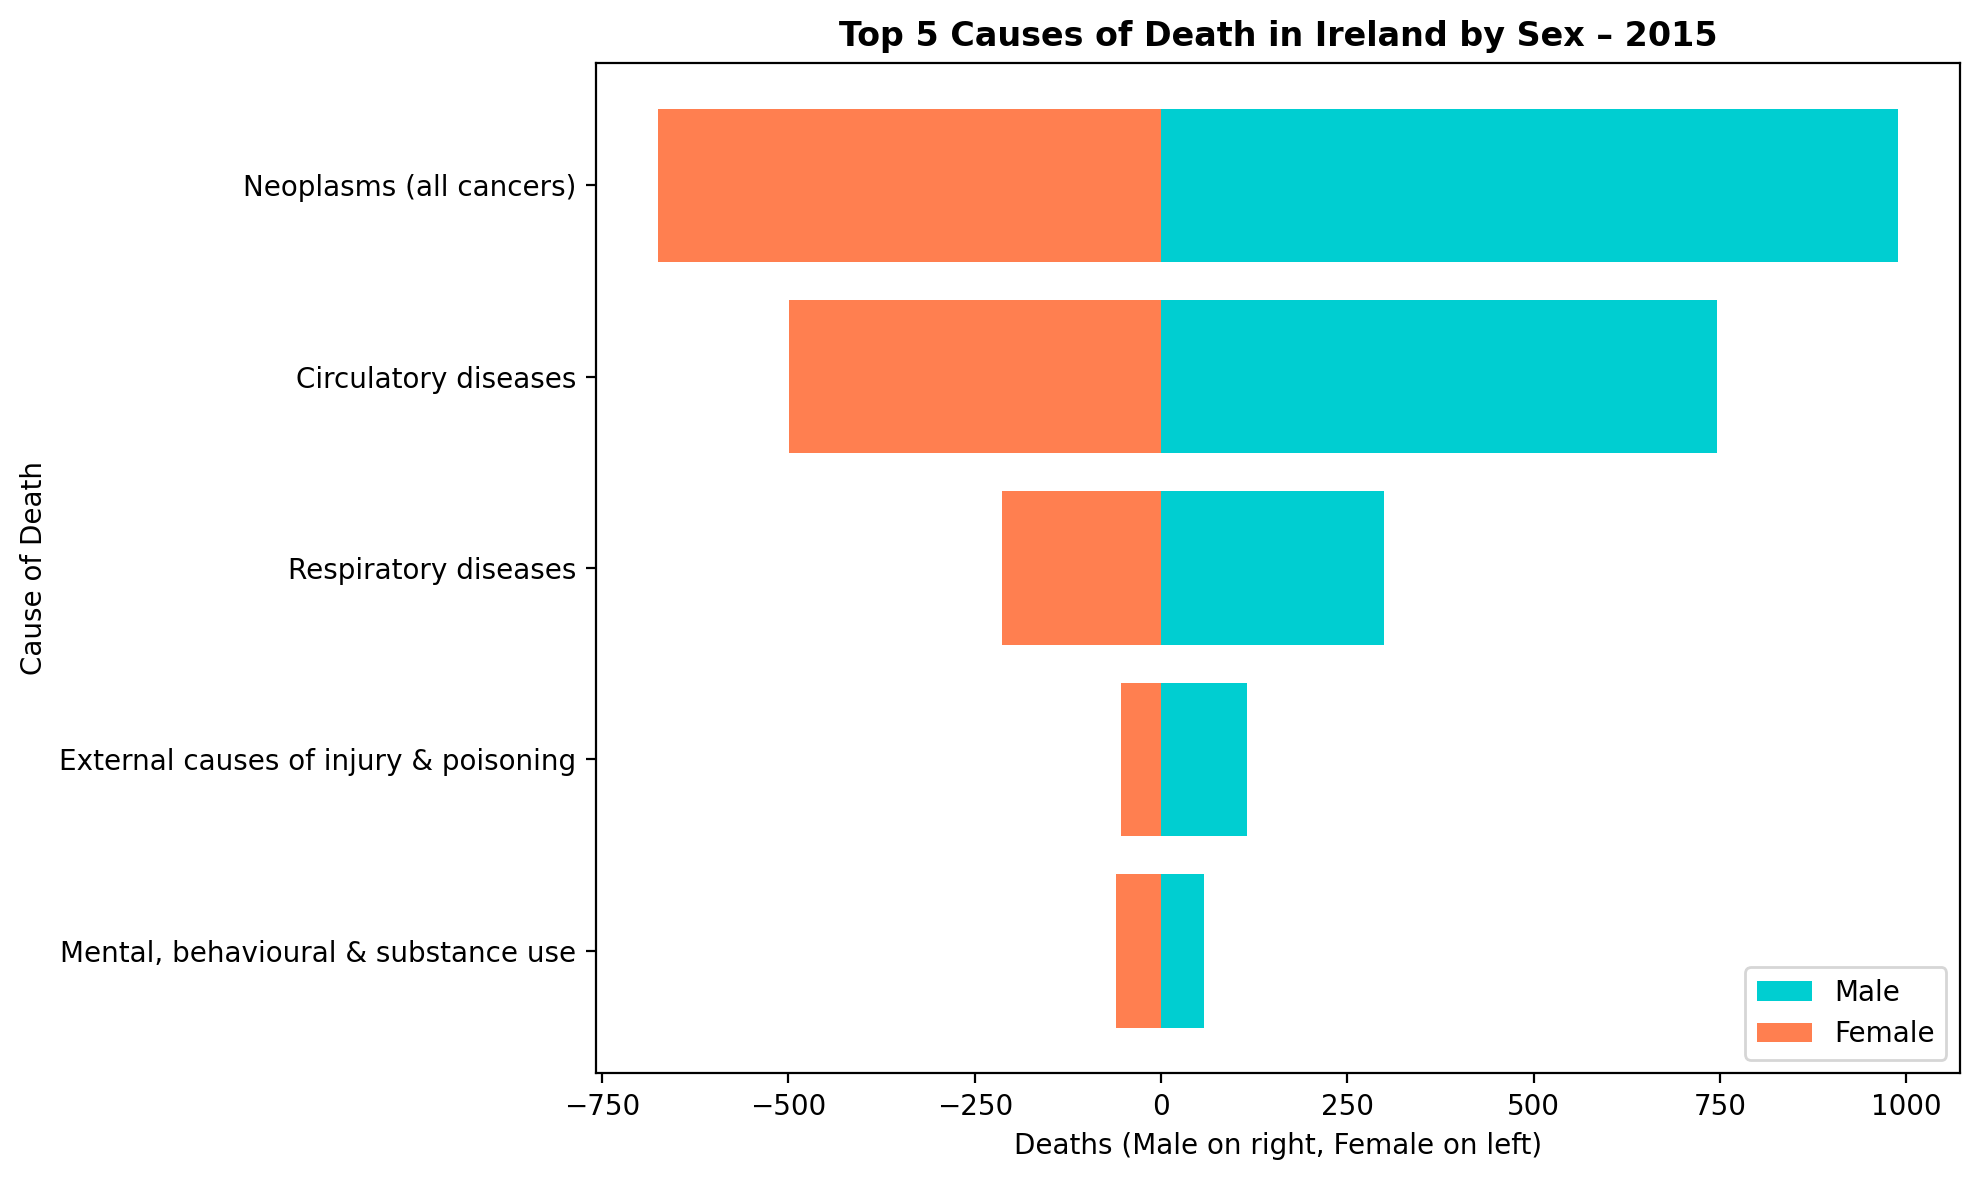

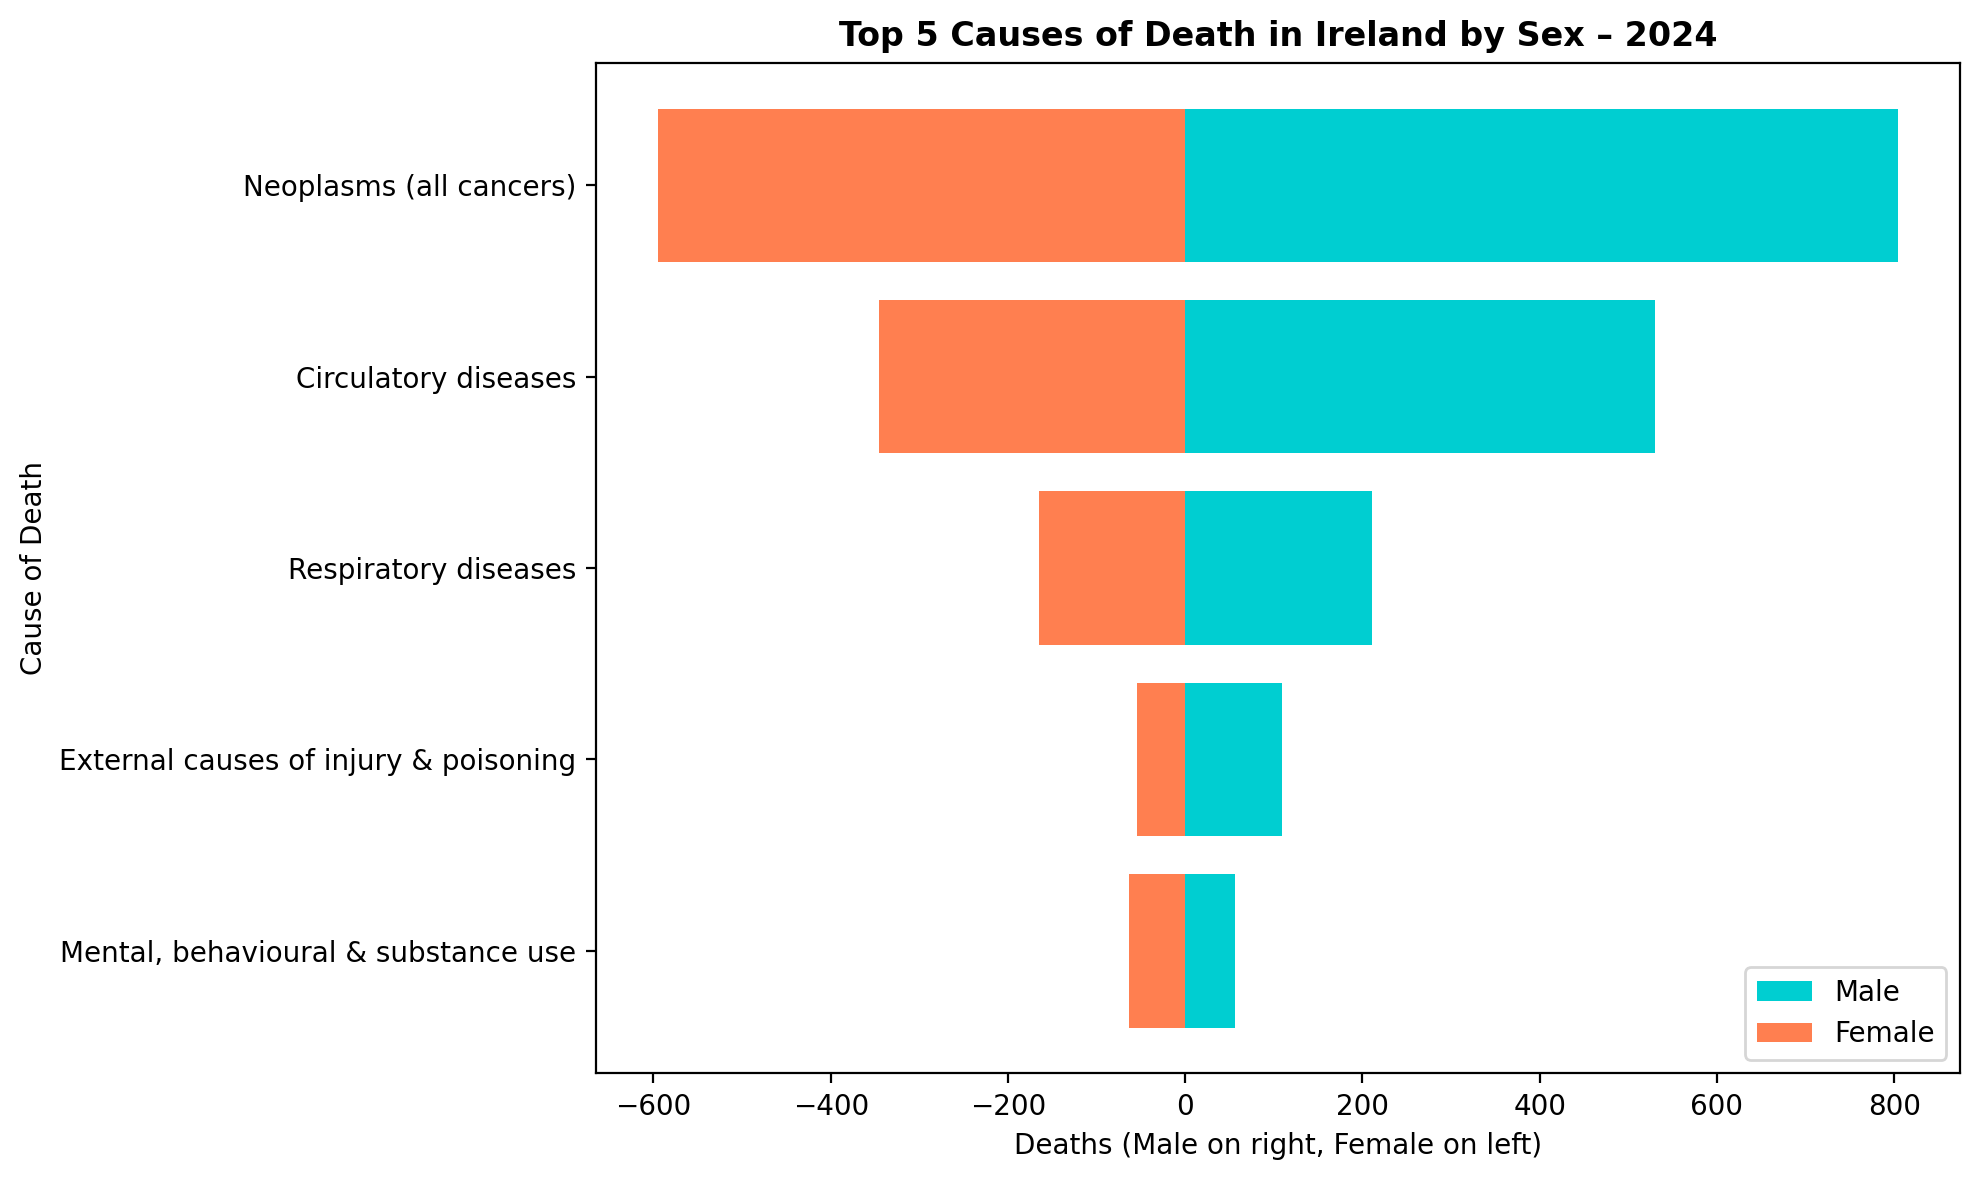

In [34]:
plot_top_5_pyramid(df, 2015, top_5_causes)
plot_top_5_pyramid(df, 2024, top_5_causes)

With our pyramid built, we now have a good idea of some changes from 2015 to 2024. While once again, all causes of death have decreases due to better health across both genders, there's one particular increase in 2024, which is Mental, behavioral & substance use. It seems that for the females this increased slightly overall, in the last 9 years. This can coincide with an increase of cocaine use in Ireland, particularly by women in recent years20.

#### 2.5.3 Regional Overview:

### References:

1. Repository organisation (GitHub Gist)
(2025) ‘How to organize your Python data science project’, GitHub Gist. Available at: https://gist.github.com/ericmjl/27e50331f24db3e8f957d1fe7bbbe510
 (Accessed: 1 December 2025).

2. Missing data in Pandas (GeeksforGeeks)
GeeksforGeeks (2025) ‘Working with Missing Data in Pandas’. Available at: https://www.geeksforgeeks.org/data-analysis/working-with-missing-data-in-pandas/
 (Accessed: 4 December 2025). 

3. ChatGPT clarification about empty DataFrames (duplicates)
OpenAI (2025) ChatGPT response to “Clarifying if empty dataframes meant that no duplicates were found”, 4 December. Available at: https://chatgpt.com/share/6931d4c6-1c98-800b-9281-3ad3f9c30654
 (Accessed: 4 December 2025).

4. Finding 0 Values in Dataframes (Stack Overflow)
‘How to find if if a particular column has zero value in a dataframe?’, Stack Overflow. Available at: https://stackoverflow.com/questions/71989791/how-to-find-if-if-a-particular-column-has-zero-value-in-a-dataframe
 (Accessed: 4 December 2025). 

5. Cumulative incidence concept (Britannica)
McNutt, Loise-Anne. (n.d.) ‘Cumulative incidence’, Encyclopaedia Britannica. Available at: https://www.britannica.com/science/cumulative-incidence
 (Accessed: 4 December 2025). 

6. Two reports from the EU and the WHO that showcase their standard mage metric for mortality
    - 6.1 WHO report on avoidable / premature mortality (NCDs)
    World Health Organization Regional Office for Europe (2025) Avoidable mortality, risk factors and policies for tackling noncommunicable diseases – leveraging data for impact: monitoring commitments in the WHO European Region ahead of the Fourth United Nations High-Level Meeting. Copenhagen: WHO Regional Office for Europe. Available at: https://www.drugsandalcohol.ie/43599/1/WHO-EURO-2025-12445-52219-80271.pdf
    (Accessed: 4 December 2025). 

    - 6.2 Eurostat article on avoidable deaths under 75
    Eurostat (2020) ‘Two-thirds of deaths under 75 could have been avoided’, Eurostat News, 14 August. Available at: https://ec.europa.eu/eurostat/web/products-eurostat-news/-/ddn-20200814-1
    (Accessed: 4 December 2025). 

7. Boolean indexing with "isin" and "~" (Medium)
Hey Amit (2025) ‘Understanding isin with ~ (NOT) in Pandas’, Medium, 20 February. Available at: https://medium.com/@heyamit10/understanding-isin-with-not-in-pandas-b20099c4ed63
 (Accessed: 4 December 2025). 

8. Replacing values in Pandas (Towards Data Science)
Towards Data Science (n.d.) ‘How to replace values in Pandas’. Available at: https://towardsdatascience.com/how-to-replace-values-in-pandas-609ba7a031c9/
 (Accessed: 4 December 2025).

9. https://leanscape.io/demystifying-standard-deviation-a-beginners-guide/ - On Standard Deviation - 12 December

10. https://www.luzmo.com/blog/chart-types - for more plot ideas - 14 December

11. Deaths & plotting ideas (CSO)
Central Statistics Office (n.d.) ‘Deaths 2022’, Vital Statistics Annual Report 2022. Available at: https://www.cso.ie/en/releasesandpublications/ep/p-vsar/vitalstatisticsannualreport2022/deaths2022/
 (Accessed: 4 December 2025).

 12. https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html - For grouped bar charts - 14 December

 13. https://chatgpt.com/share/693ef4f5-a7f4-800b-bdab-b6d656453acc - For the grouped bar chart code - 14 December

 14. https://medium.com/data-science/7-visualizations-with-python-to-handle-multivariate-categorical-data-63158db0911d - On ideas for multidimensional categorical data problem - 15 December

 15. https://chatgpt.com/share/694059f0-a354-800b-8a67-4a61ea91a801 - discussions on best plot for Sex and Ages plot - 15 December

 16. https://www.geeksforgeeks.org/python/create-a-stacked-bar-plot-in-matplotlib/ - on stacked barplots - 16 December

 17. https://icd.who.int/browse10/2016/en#/XVII - On how causes of death are organised - 19 December

 18. https://chatgpt.com/share/694597d9-6330-800b-b5f9-b4652f2c947a - Discussions on organising causes of death - 19 December

 19. https://coderzcolumn.com/tutorials/data-science/population-pyramid-chart-using-matplotlib - On Pyramid plots - 23 December

 20. https://www.mentalhealthireland.ie/wp-content/uploads/2025/10/MHI-2025-Research_-Key-Findings.pdf - On women's overal mental health - 24 December